# Stress Levels in Canada
### Exploring Determinants of Stress in the Canadian Community Health Survey

Stress has become a defining feature of modern life. Social and economic pressures, global political shifts, financial instability, and rapid technological change all contribute to growing uncertainty, with potential consequences for individual and public health.

This project investigates the relationship between various social factors, stress levels, and mental health across Canada. Based on a complex national survey, it focuses on a selected set of features and applies methods of exploratory data analysis (EDA), statistics, and data visualization. The main goal is to provide an overall picture, identifying correlations related to stress as well as the degree to which stress may influence mental health. Potentially, this work could be extended into a more specific or in-depth analysis.

### Data Source.

The project is based on the **Canadian Community Health Survey, 2019–2020: Annual Component** — a comprehensive initiative by Statistics Canada, which regularly surveys to support improvements in health services and address health-related challenges across the population. The data was published in June 2024 as the [Canadian Community Health Survey: Public Use Microdata File](https://www150.statcan.gc.ca/n1/pub/82m0013x/82m0013x2024001-eng.htm), and is used here for educational and research purposes.

The [study documentation](https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/ZVCGBK) is available via Borealis, the Canadian Dataverse Repository. It can be accessed under the **Metadata** tab by selecting the **Export Metadata** option.

*Adapted from Statistics Canada, Canadian Community Health Survey: Public Use Microdata File, 2019/2020, June 23, 2025. This does not constitute an endorsement by Statistics Canada of this product.*

### Project Structure.

#### 1. Data Exploration and Cleaning  
The raw data is cleaned, explored, filtered, and prepared for analysis. For clarity and focus, the dataset is organized into several thematic treks to investigate stress levels in relation to specific aspects of life.

#### 2. Exploratory Data Analysis (EDA): Stress Levels  
This stage explores the segmented data by visualizing relationships between various features and perceived stress levels, supported by basic statistical analysis.

#### 3. Exploratory Data Analysis (EDA): Health Factors
This section explores specific relationships between perceived stress and various health factors.

#### 4. Exploratory Machine Learning  
To further investigate the relationship between stress and health, basic modeling techniques are applied, providing an additional layer of insight.

#### 5. Tableau Presentation  
The key findings are summarized and visualized through interactive dashboards for a more accessible presentation.

---


### 1. Data Exploration and Cleaning
To begin, I load the necessary libraries and read in the data file.

In [3]:
# Load packages
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [4]:
# Read csv file
cchs = pd.read_csv('/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/data/pumf_cchs.csv')
cchs.shape

(108252, 691)

The dataset is based on a nationwide survey with over 108,000 respondents. By design, the survey is complex and consists mostly of health-related and socio-demographic questions, many of which are highly detailed.

Based on the survey documentation tables, I will select a limited number of features from the 691 available.

In [6]:
# Create a list of columns
columns_to_keep = [
    'GEOGPRV',
    'DHH_SEX', 'DHHGMS', 'DHHDGHSZ', 'DHHGAGE', 'EHG2DVH3',
    'GEN_005', 'GEN_015', 'GEN_020', 'GEN_025', 'GEN_030', 'CMH_005',
    'MAC_010', 'INCDGHH',
    'SDC_015', 'SDCDVIMM', 'SDCDVFLA'
]

In [7]:
# Filter the dataframe
cchs = cchs[columns_to_keep]
cchs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108252 entries, 0 to 108251
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   GEOGPRV   108252 non-null  float64
 1   DHH_SEX   108252 non-null  float64
 2   DHHGMS    108252 non-null  float64
 3   DHHDGHSZ  108252 non-null  float64
 4   DHHGAGE   108252 non-null  float64
 5   EHG2DVH3  108252 non-null  float64
 6   GEN_005   108252 non-null  float64
 7   GEN_015   108252 non-null  float64
 8   GEN_020   108252 non-null  float64
 9   GEN_025   108252 non-null  float64
 10  GEN_030   108252 non-null  float64
 11  CMH_005   108252 non-null  float64
 12  MAC_010   108252 non-null  float64
 13  INCDGHH   108252 non-null  float64
 14  SDC_015   108252 non-null  float64
 15  SDCDVIMM  108252 non-null  float64
 16  SDCDVFLA  108252 non-null  float64
dtypes: float64(17)
memory usage: 14.0 MB


As shown above, the selected subset consists of 108,252 non-null entries across 19 features. The values are stored as numerical (`float64`) types. The documentation provides reference tables, which I will use to decode column names and values.

First, I will rename the columns.

In [9]:
# Create a renaming dictionary
rename_dict = {
    'GEOGPRV': 'province',
    'DHH_SEX': 'sex',
    'DHHGMS': 'marital_status',
    'DHHDGHSZ': 'household_size',
    'DHHGAGE': 'age_group',
    'EHG2DVH3': 'education_level_household',
    'GEN_005': 'perceived_health',
    'GEN_015': 'perceived_mh',
    'GEN_020': 'perceived_life_stress',
    'GEN_025': 'perceived_stress_at_work',
    'GEN_030': 'community_belonging',
    'CMH_005': 'consulted_mh_prof',
    'MAC_010': 'job_business_12m',
    'INCDGHH': 'income_household',
    'SDC_015': 'aboriginal_ident',
    'SDCDVIMM': 'immigrant_flag',
    'SDCDVFLA': 'visible_minority'
}

# Rename columns
cchs.rename(columns=rename_dict, inplace=True)
cchs.head()

,province,sex,marital_status,household_size,age_group,education_level_household,perceived_health,perceived_mh,perceived_life_stress,perceived_stress_at_work,community_belonging,consulted_mh_prof,job_business_12m,income_household,aboriginal_ident,immigrant_flag,visible_minority
0,47.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,6.0,1.0,5.0,2.0,2.0,2.0
1,47.0,1.0,1.0,2.0,5.0,2.0,3.0,3.0,3.0,6.0,3.0,6.0,6.0,4.0,2.0,2.0,2.0
2,59.0,2.0,2.0,1.0,5.0,1.0,2.0,3.0,3.0,6.0,2.0,2.0,6.0,2.0,2.0,2.0,2.0
3,13.0,1.0,2.0,1.0,5.0,1.0,3.0,3.0,3.0,6.0,2.0,6.0,6.0,3.0,2.0,2.0,2.0
4,46.0,1.0,2.0,1.0,4.0,3.0,5.0,5.0,4.0,6.0,3.0,2.0,2.0,1.0,2.0,2.0,2.0


The `float64` data type is likely an artifact of pandas reading the CSV file. For convenience, I will convert these values back to integers, as originally used in the survey.

In [11]:
# Change the datatype to int
cchs = cchs.astype(int)

Next, I will map the values according to the documentation tables.

In [13]:
# Create a map for values
value_maps = {
    'sex': {
        1: 'Male',
        2: 'Female',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'marital_status': {
        1: 'Married/Common-law',
        2: 'Widowed/Divorced/Separated/Single, never married',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'household_size': {
        1: 'Lives alone (household size=1)',
        2: 'Household size 2 or more',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'age_group': {
        1: '12 to 17 years',
        2: '18 to 34 years',
        3: '35 to 49 years',
        4: '50 to 64 years',
        5: '65 and older',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'education_level_household': {
        1: 'Less than secondary school graduation',
        2: 'Secondary school graduation, no post-secondary education',
        3: 'Post-secondary certificate/diploma / university degree',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'perceived_health': {
        1: 'Excellent',
        2: 'Very good',
        3: 'Good',
        4: 'Fair',
        5: 'Poor',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'perceived_mh': {
        1: 'Excellent',
        2: 'Very good',
        3: 'Good',
        4: 'Fair',
        5: 'Poor',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'perceived_life_stress': {
        1: 'Not at all stressful',
        2: 'Not very stressful',
        3: 'A bit stressful',
        4: 'Quite a bit stressful',
        5: 'Extremely stressful',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'perceived_stress_at_work': {
        1: 'Not at all stressful',
        2: 'Not very stressful',
        3: 'A bit stressful',
        4: 'Quite a bit stressful',
        5: 'Extremely stressful',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'community_belonging': {
        1: 'Very strong',
        2: 'Somewhat strong',
        3: 'Somewhat weak',
        4: 'Very weak',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'consulted_mh_prof': {
        1: 'Yes',
        2: 'No',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'job_business_12m': {
        1: 'Yes',
        2: 'No',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'income_household': {
        1: 'No income or less than $20,000',
        2: '$20,000 to $39,999',
        3: '$40,000 to $59,999',
        4: '$60,000 to $79,999',
        5: '$80,000 or more',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'aboriginal_ident': {
        1: 'Yes',
        2: 'No',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'immigrant_flag': {
        1: 'Landed immigrant / non-permanent resident',
        2: 'Non-immigrant (Canadian born)',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    },
    'visible_minority': {
        1: 'Visible minority',
        2: 'Not a visible minority',
        6: 'Valid skip',
        7: "Don't know",
        8: 'Refusal',
        9: 'Not stated'
    }
}

In [14]:
# Apply the map
for col, mapping in value_maps.items():
    if col in cchs.columns:
        cchs[col] = cchs[col].map(mapping)
cchs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108252 entries, 0 to 108251
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   province                   108252 non-null  int64 
 1   sex                        108252 non-null  object
 2   marital_status             108252 non-null  object
 3   household_size             108252 non-null  object
 4   age_group                  108252 non-null  object
 5   education_level_household  108252 non-null  object
 6   perceived_health           108252 non-null  object
 7   perceived_mh               108252 non-null  object
 8   perceived_life_stress      108252 non-null  object
 9   perceived_stress_at_work   108252 non-null  object
 10  community_belonging        108252 non-null  object
 11  consulted_mh_prof          108252 non-null  object
 12  job_business_12m           108252 non-null  object
 13  income_household           108252 non-null  

In [15]:
cchs.head()

,province,sex,marital_status,household_size,age_group,education_level_household,perceived_health,perceived_mh,perceived_life_stress,perceived_stress_at_work,community_belonging,consulted_mh_prof,job_business_12m,income_household,aboriginal_ident,immigrant_flag,visible_minority
0,47,Female,Married/Common-law,Household size 2 or more,35 to 49 years,Post-secondary certificate/diploma / universit...,Good,Good,Not very stressful,Not very stressful,Somewhat strong,Valid skip,Yes,"$80,000 or more",No,Non-immigrant (Canadian born),Not a visible minority
1,47,Male,Married/Common-law,Household size 2 or more,65 and older,"Secondary school graduation, no post-secondary...",Good,Good,A bit stressful,Valid skip,Somewhat weak,Valid skip,Valid skip,"$60,000 to $79,999",No,Non-immigrant (Canadian born),Not a visible minority
2,59,Female,"Widowed/Divorced/Separated/Single, never married",Lives alone (household size=1),65 and older,Less than secondary school graduation,Very good,Good,A bit stressful,Valid skip,Somewhat strong,No,Valid skip,"$20,000 to $39,999",No,Non-immigrant (Canadian born),Not a visible minority
3,13,Male,"Widowed/Divorced/Separated/Single, never married",Lives alone (household size=1),65 and older,Less than secondary school graduation,Good,Good,A bit stressful,Valid skip,Somewhat strong,Valid skip,Valid skip,"$40,000 to $59,999",No,Non-immigrant (Canadian born),Not a visible minority
4,46,Male,"Widowed/Divorced/Separated/Single, never married",Lives alone (household size=1),50 to 64 years,Post-secondary certificate/diploma / universit...,Poor,Poor,Quite a bit stressful,Valid skip,Somewhat weak,No,No,"No income or less than $20,000",No,Non-immigrant (Canadian born),Not a visible minority


The decoding was completed successfully. Out of 108,252 rows, no data was lost. A quick overview shows that most columns have now been converted to `'object'` format, with only province and health region codes remaining as integers. The data in the DataFrame is categorical. In the context of public surveys, respondents are typically given a predefined list of response options. As a result, many variables are ordinal in nature and often encoded numerically, typically on a scale from 1 to 5 — as is the case with many questions in this survey.

Decoding the categories and reassigning their string values also reveals that some numeric codes represent missing or non-informative responses from participants. In other words, even though the values are technically present in the dataset (i.e., non-null), they do not carry specific meaning.

Common examples include categories like *"Don't know"*, *"Refusal"*, or *"Valid skip"*. While such responses might be considered in detailed investigations, they often add noise and blur the overall picture. For the sake of accuracy, these values will not be removed from the data entirely, but they will be excluded from plots and statistical tables for clarity. 

An exception will be made for the `perceived_life_stress` variable — the target of the following analysis. Rows with non-informative responses in this column will be removed from the dataset.

I will now examine the values for `perceived_life_stress` and filter the dataset accordingly.

In [17]:
cchs['perceived_life_stress'].value_counts()

perceived_life_stress
A bit stressful          40711
Not very stressful       29404
Not at all stressful     18893
Quite a bit stressful    16012
Extremely stressful       2803
Don't know                 380
Refusal                     49
Name: count, dtype: int64

In [18]:
# Remove 'Don't know' and 'Refusal' from target
valid_stress_levels = [
    'Not at all stressful',
    'Not very stressful',
    'A bit stressful',
    'Quite a bit stressful',
    'Extremely stressful'
]

# Keep only valid responses
cchs = cchs[cchs['perceived_life_stress'].isin(valid_stress_levels)]
cchs.shape

(107823, 17)

The shape of the dataset was reduced only slightly, with 429 rows removed out of 108,252.

The 17 selected columns (from the original 691) reflect different dimensions of the respondents' lives — including demographic, economic, social, and health-related factors. To better organize the analysis, I will group these variables into thematic groups covering Demographic, Socioeconomic, Social, Cultural and Ethnic Identity, Geographic, and Health factors. This organization allows for a focused investigation of how different life domains may influence stress levels.

In the next step, I will create subsets based on each trek.

In [20]:
# Create subsets according to trek
cchs_dem = cchs[['age_group', 'sex', 'marital_status', 'perceived_life_stress']]
cchs_fin = cchs[['job_business_12m', 'income_household', 'education_level_household', 'perceived_stress_at_work', 'perceived_life_stress']]
cchs_soc = cchs[['marital_status', 'household_size', 'community_belonging', 'perceived_life_stress']]
cchs_ident = cchs[['aboriginal_ident', 'immigrant_flag', 'visible_minority', 'perceived_life_stress']]
cchs_reg = cchs[['province', 'perceived_life_stress']]
cchs_health = cchs[['perceived_health', 'perceived_mh', 'consulted_mh_prof', 'perceived_life_stress']]

### 2. Exploratory Data Analysis (EDA): Stress Levels

#### Demographic Factors

To start exploring stress levels, I focus on basic demographic factors like age group, sex at birth, and marital status. Since the CCHS dataset is primarily designed for detailed health analysis, demographic variables are somewhat limited.

While working through this thematic group, I will establish a template to apply consistently across other groups. This process involves three steps:  
1. Examining value counts across categories,  
2. Creating bar plots to visualize stress levels within each category, and  
3. Generating a statistical summary table to assess the association between each feature and stress levels.

Next, I will define a function to count category frequencies and calculate percentages within each feature.

In [24]:
# Create a function for counting values and showing percentage
def print_value_counts_with_percent(df, target_col='perceived_life_stress'):
    """
    Prints absolute and percentage value counts for all columns
    except the specified target column.
    """
    for col in df.columns:
        if col != target_col:
            print(f"\n{col} value counts (absolute and %):")
            counts = df[col].value_counts(dropna=False)
            percentages = df[col].value_counts(normalize=True, dropna=False) * 100
            summary = pd.DataFrame({'Count': counts, 'Percent': percentages.round(1)})
            display(summary)

In [25]:
print_value_counts_with_percent(cchs_dem)


age_group value counts (absolute and %):


,Count,Percent
age_group,,
65 and older,47712,44.3
50 to 64 years,21608,20.0
35 to 49 years,16775,15.6
18 to 34 years,15250,14.1
12 to 17 years,6478,6.0



sex value counts (absolute and %):


,Count,Percent
sex,,
Female,58735,54.5
Male,49088,45.5



marital_status value counts (absolute and %):


,Count,Percent
marital_status,,
Married/Common-law,55684,51.6
"Widowed/Divorced/Separated/Single, never married",45290,42.0
Valid skip,6478,6.0
Not stated,371,0.3


**44.3%** of respondents are 65 years old or older. The next largest group is 50 to 64 years old, making up **20%**. The other age groups are smaller. Although the other groups cover comparable age intervals (12–17, 18–34, 35–49, 50–64), the number of respondents in the oldest group is significantly higher. It is also true that health issues tend to become more important with age.

The female-to-male ratio among respondents is **54.5%** to **45.5%**.

At the time of the survey, **51.6%** were married, while **42%** were not.

The ‘Valid skip’ category for marital status includes **6,478** respondents, which matches the count for the 12 to 17 age group.

The function below will rename these categories for easier interpretation and plotting in later analysis.

In [27]:
# Create a function to rename categories
def rename_categories_multiple(df, rename_map_dict):
    """
    Rename categories for multiple columns based on a dictionary of dictionaries.
    """
    df_copy = df.copy()
    for col, rename_dict in rename_map_dict.items():
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].replace(rename_dict)
    return df_copy

In [28]:
# Set a rename map
rename_map = {
    'marital_status': {
        'Widowed/Divorced/Separated/Single, never married': 'Non-married',
        'Married/Common-law': 'Married'
    }
}

# Rename categories
cchs_dem = rename_categories_multiple(cchs_dem, rename_map)

The next cell contains the core functions I use for exploring stress levels across different categorical variables. First, I clean the data by filtering out non-informative responses like ‘Valid skip’, ‘Not stated’, ‘Don’t know’, and ‘Refusal’ to keep the visualizations clear. Then, I convert raw counts into percentages and create bar plots to show how stress levels distribute across each category, applying a consistent color palette and ordering for easy comparison.

In parallel, I calculate chi-square statistics and corrected Cramér’s V to measure the strength and significance of associations between variables. This statistical summary also tracks how many responses were excluded.

Finally, a main wrapper function combines these steps, producing both the visualizations and a sortable table of results, creating a structured and repeatable workflow for analyzing perceived life stress in the dataset.

In [30]:
# 1. Compute corrected Cramér's V
def compute_cramers_v(confusion_matrix):
    """
    Calculates corrected Cramér's V statistic from a contingency table.
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 2. Filter out unwanted values from the data
def filter_valid_responses(df, feature, target_col, exclude_values):
    """
    Filters rows where feature or target_col contain excluded values.
    """
    mask = df[feature].isin(exclude_values) | df[target_col].isin(exclude_values)
    return df[~mask].copy(), mask.sum()

# 3. Convert counts to percentages for bar plotting
def counts_to_percentage(df, category_col, target_col):
    """
    Converts grouped counts to percentages for each category.
    """
    counts = df.groupby([category_col, target_col]).size().reset_index(name='count')
    totals = df.groupby(category_col).size().reset_index(name='total')
    merged = counts.merge(totals, on=category_col)
    merged['percent'] = (merged['count'] / merged['total']) * 100
    return merged

# 4. Plot percentage barplots
def plot_stress_bars(df, var_list, target_col, palette, title_prefix, stress_order):
    """
    Creates bar plots of stress percentages for each variable.
    """
    n_vars = len(var_list)
    n_cols = 2
    n_rows = (n_vars + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 8 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(var_list):
        filtered_df, _ = filter_valid_responses(df, feature, target_col, exclude_values=[
            'Valid skip', 'Not stated', "Don't know", 'Refusal'
        ])
        if filtered_df[feature].nunique() < 2:
            axes[i].axis('off')
            continue

        percent_df = counts_to_percentage(filtered_df, feature, target_col)
        percent_df[target_col] = pd.Categorical(percent_df[target_col], categories=stress_order, ordered=True)

        # Apply custom order to the feature if defined
        if 'ordinal_orders' in globals() and feature in ordinal_orders:
            percent_df[feature] = pd.Categorical(
            percent_df[feature],
            categories=ordinal_orders[feature],
            ordered=True
            )

        sns.barplot(
            data=percent_df,
            x='percent',
            y=feature,
            hue=target_col,
            hue_order=stress_order,
            ax=axes[i],
            palette=palette
        )

        axes[i].set_title(f'{title_prefix}{feature} vs Stress (Percent)', fontsize=14)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].xaxis.grid(True, linestyle='--', alpha=0.6)
        axes[i].legend_.remove()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Stress Level', loc='lower center', ncol=5,
               fontsize=11, title_fontsize=13, frameon=False, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

# 5. Calculate statistics per feature
def calculate_statistics(df, var_list, target_col):
    """
    Runs chi-square tests and computes Cramér’s V per variable.
    """
    results = []
    exclude_values = ['Valid skip', 'Not stated', "Don't know", 'Refusal']

    for feature in var_list:
        filtered_df, excluded_count = filter_valid_responses(df, feature, target_col, exclude_values)

        if filtered_df[feature].nunique() < 2:
            continue

        contingency_table = pd.crosstab(filtered_df[feature], filtered_df[target_col])
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            continue

        chi2, p, _, _ = chi2_contingency(contingency_table)
        v = compute_cramers_v(contingency_table)

        strength = (
            'Weak' if v < 0.1 else
            'Moderate' if v < 0.3 else
            'Strong'
        )
        p_val_display = "<0.001" if p < 0.001 else round(p, 3)

        results.append({
            'Variable': feature,
            'Chi-square value': round(chi2, 3),
            'p-value': p_val_display,
            'Cramér’s V': round(v, 3),
            'Interpretation': strength,
            'Excluded count': excluded_count
        })

    return pd.DataFrame(results).sort_values(by='Cramér’s V', ascending=False).reset_index(drop=True)

# 6. Main wrapper function
def analyze_and_plot(df, var_list=None, target_col='perceived_life_stress', palette='coolwarm', title_prefix=''):
    """
    Performs both bar plotting and statistical testing on a list of categorical variables.
    """
    if var_list is None:
        var_list = [col for col in df.columns if col != target_col]
    
    stress_order = [
        'Not at all stressful',
        'Not very stressful',
        'A bit stressful',
        'Quite a bit stressful',
        'Extremely stressful'
    ]

    plot_stress_bars(df, var_list, target_col, palette, title_prefix, stress_order)
    print('')
    stats_df = calculate_statistics(df, var_list, target_col)
    return stats_df


Below are the bar plots and the corresponding statistical table for the subset of Demographic Factors:

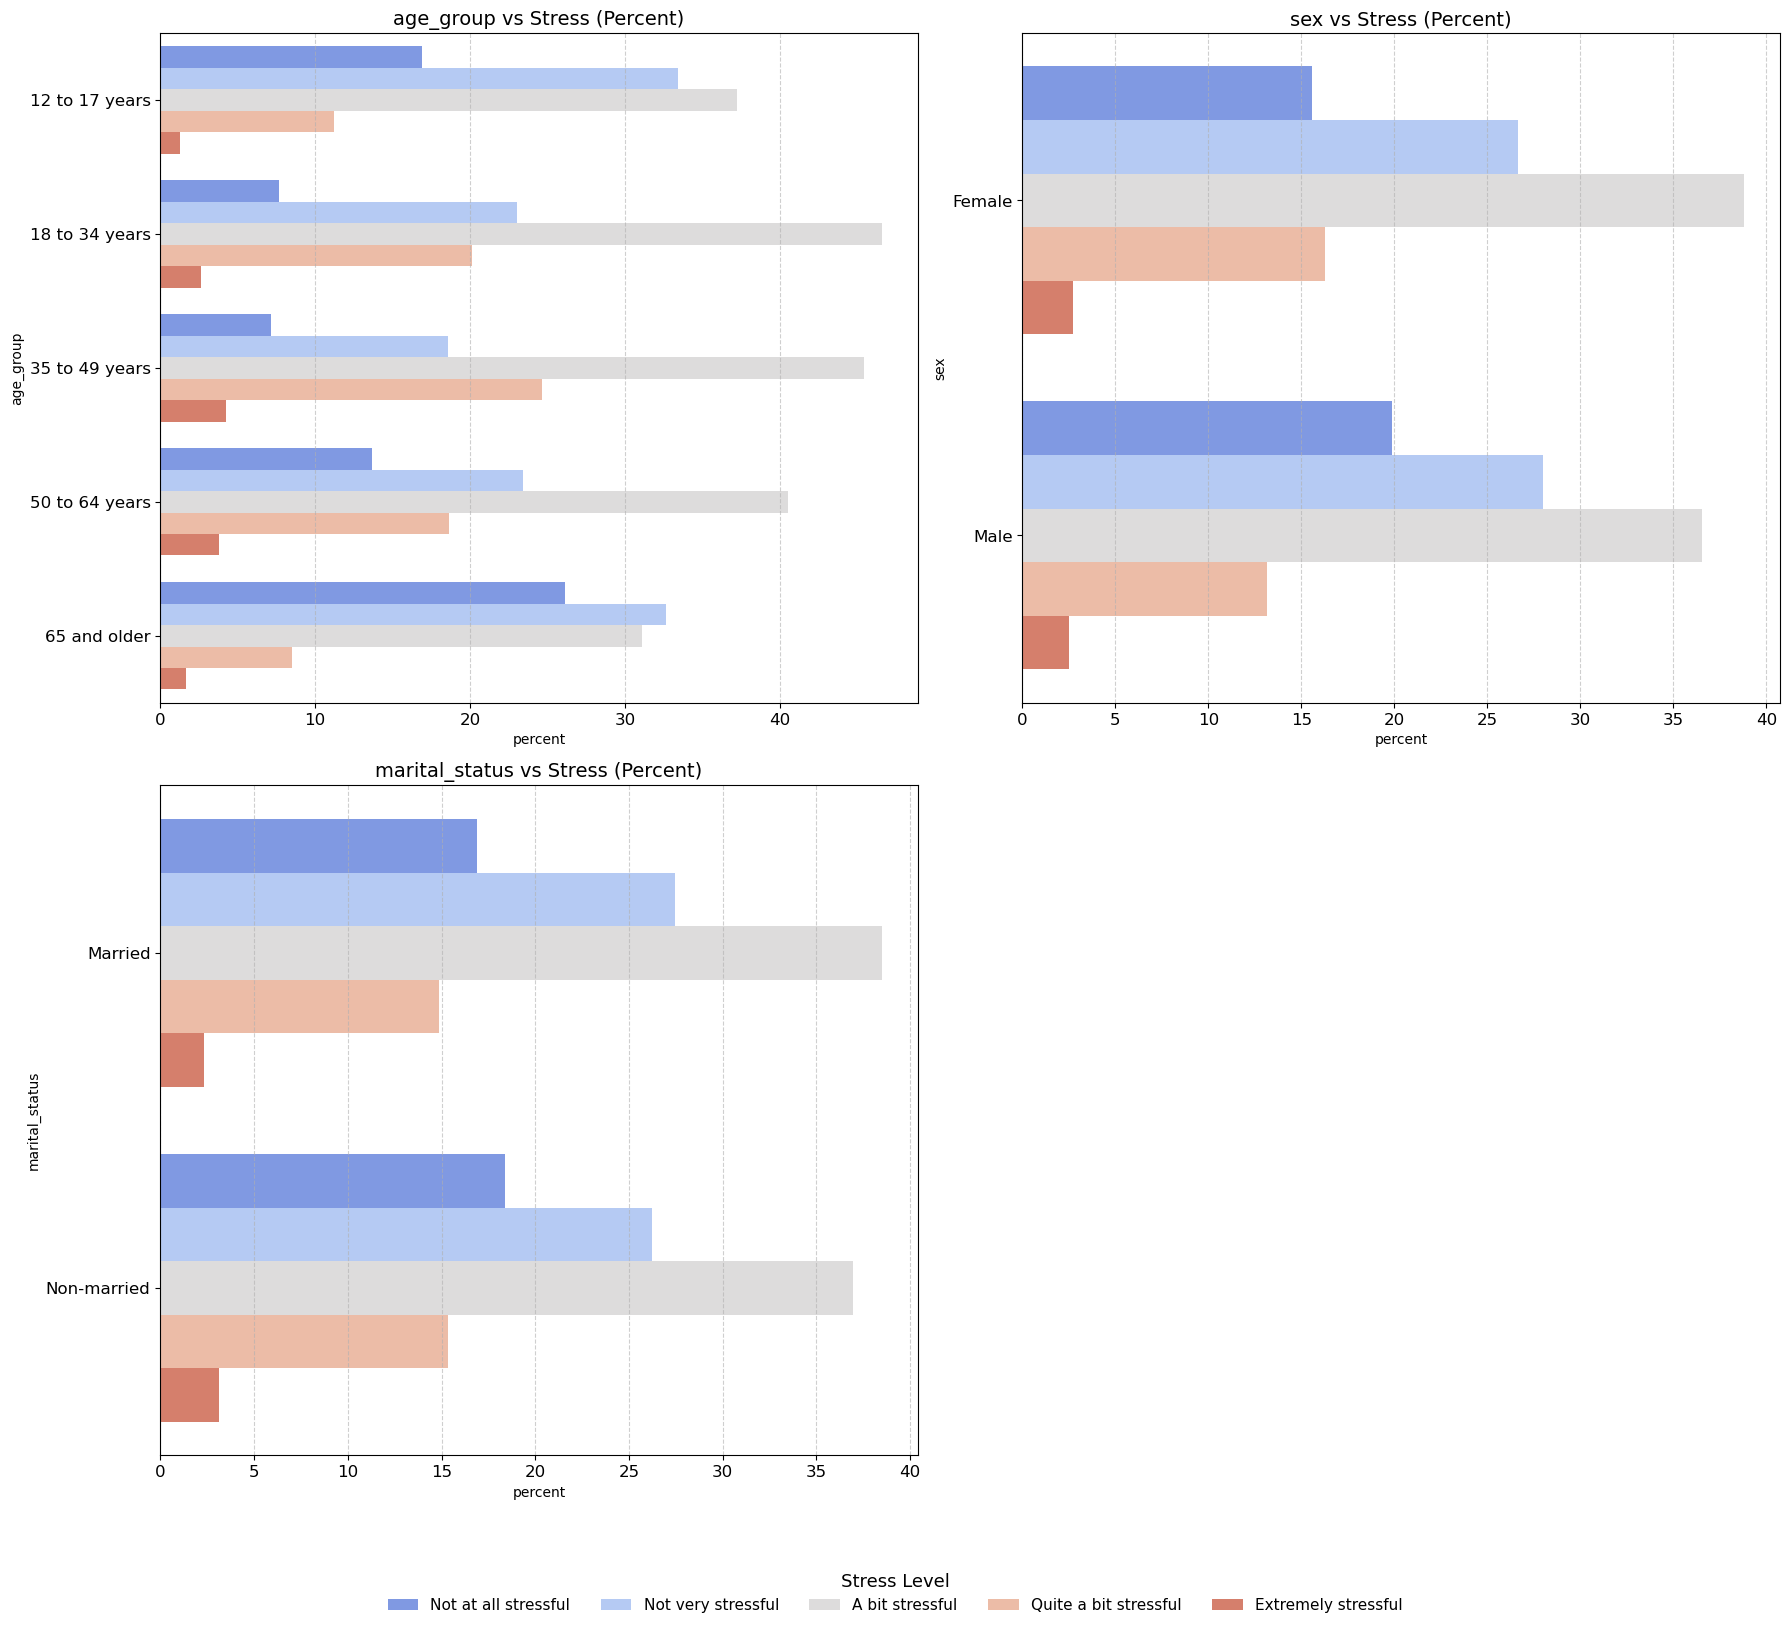

,Variable,Chi-square value,p-value,Cramér’s V,Interpretation,Excluded count
0,age_group,9951.635,<0.001,0.152,Moderate,0
1,sex,515.050,<0.001,0.069,Weak,0
2,marital_status,130.258,<0.001,0.035,Weak,6849


In [32]:
analyze_and_plot(cchs_dem)

Self-perceived stress is comparably low among the youngest age group (12–17), while the two older age groups tend to report higher stress levels. Interestingly, after age 50, respondents generally report that life feels less stressful, with those 65 and older even less stressed than the youngest group.

Females report higher life stress than males, particularly in the categories “Very stressful” and “A bit stressful.”

Married individuals report extreme stress slightly less often than those who are not married, although the numbers vary across other stress categories.

The table:

- **Age group** shows a statistically significant association with stress levels (Chi-square = 9951.635, p < 0.001) and a moderate effect size (Cramér’s V = 0.152), indicating age is an important factor related to stress in this dataset.

- **Sex** also has a significant but weaker association (Chi-square = 515.050, p < 0.001) with a weak effect size (Cramér’s V = 0.069), suggesting some relationship but less pronounced.

- **Marital status** has a statistically significant association as well (Chi-square = 130.258, p < 0.001) but with a very weak effect size (Cramér’s V = 0.035). Notably, 6,849 respondents were excluded from this analysis.

Overall, among demographic factors, age appears to be the most relevant factor related to perceived stress.

#### Socioeconomic Factors

The group of Socioeconomic Factors includes four features: participation in a job or business activity within the last year, household income, the highest level of education in the household, and perceived stress at work. This set offers a more specific scope than the basic demographics above and aims to explore the relationship between education, employment, and income on one hand, and stress levels on the other. Notably, the variable *perceived_stress_at_work* may provide a strong explanation for overall *perceived_life_stress*.

These factors are often considered key social determinants of health, and their role in shaping stress levels is especially relevant in this context — a statement that will be examined below.

As before, I will begin by examining the values and percentage distribution across categories.

In [36]:
print_value_counts_with_percent(cchs_fin)


job_business_12m value counts (absolute and %):


,Count,Percent
job_business_12m,,
Valid skip,54190,50.3
Yes,43601,40.4
No,9249,8.6
Not stated,753,0.7
Refusal,17,0.0
Don't know,13,0.0



income_household value counts (absolute and %):


,Count,Percent
income_household,,
"$80,000 or more",49231,45.7
"$20,000 to $39,999",18164,16.8
"$40,000 to $59,999",17471,16.2
"$60,000 to $79,999",14673,13.6
"No income or less than $20,000",5969,5.5
Not stated,2315,2.1



education_level_household value counts (absolute and %):


,Count,Percent
education_level_household,,
Post-secondary certificate/diploma / university degree,76613,71.1
"Secondary school graduation, no post-secondary education",15997,14.8
Less than secondary school graduation,9408,8.7
Not stated,5805,5.4



perceived_stress_at_work value counts (absolute and %):


,Count,Percent
perceived_stress_at_work,,
Valid skip,63753,59.1
A bit stressful,18033,16.7
Quite a bit stressful,10319,9.6
Not very stressful,8274,7.7
Not at all stressful,3945,3.7
Extremely stressful,2224,2.1
Not stated,1187,1.1
Don't know,75,0.1
Refusal,13,0.0


The column *job_business_12m* shows that **40.4%** of respondents reported working during the past year, while only **8.6%** answered "No." Interestingly, the "Valid skip" category is quite significant here, accounting for **50.3%** of responses. When compared to *age_group* counts, this aligns closely with the combined number of respondents in the 12–17 and 65+ categories — likely minors and retirees.

In terms of income, **45.7%** reported a household annual income of 80,000 CAD or more, while only **5.5%** reported earning less than 20,000 CAD per year.

Regarding education, **71.1%** of households have at least one person with a level of education higher than secondary school, while **8.7%** fall below that threshold.

For *perceived_stress_at_work*, the most common response was **“A bit stressful”** (**16.7%**). Other notable values include **“Extremely stressful”** at **2.1%**, and **“Not at all stressful”** at **3.7%**.

In the next step, I will prepare the data for plotting by shortening category names and explicitly ordering the categories.

In [39]:
# Set a rename map
rename_map = {
    'income_household': {
        '$80,000 or more': '80,000 +',
        '$60,000 to $79,999': '60,000 - 79,999',
        '$20,000 to $39,999': '20,000 - 39,999',
        '$40,000 to $59,999': '40,000 - 59,999',
        'No income or less than $20,000': '< 20,000'
    },
    'education_level_household': {
        'Post-secondary certificate/diploma / university degree': 'Higher than Secondary',
        'Secondary school graduation, no post-secondary education': 'Secondary',
        'Less than secondary school graduation': 'Less than Secondary'
    }
}

# Rename categories
cchs_fin = rename_categories_multiple(cchs_fin, rename_map)


# Set ordinal_orders
ordinal_orders = {
    'income_household': ['< 20,000', '20,000 - 39,999', '40,000 - 59,999', '60,000 - 79,999', '80,000 +'],
    'education_level_household': ['Less than Secondary', 'Secondary', 'Higher than Secondary'],
    'perceived_stress_at_work': ['Not at all stressful', 'Not very stressful', 'A bit stressful', 'Quite a bit stressful', 'Extremely stressful']
}

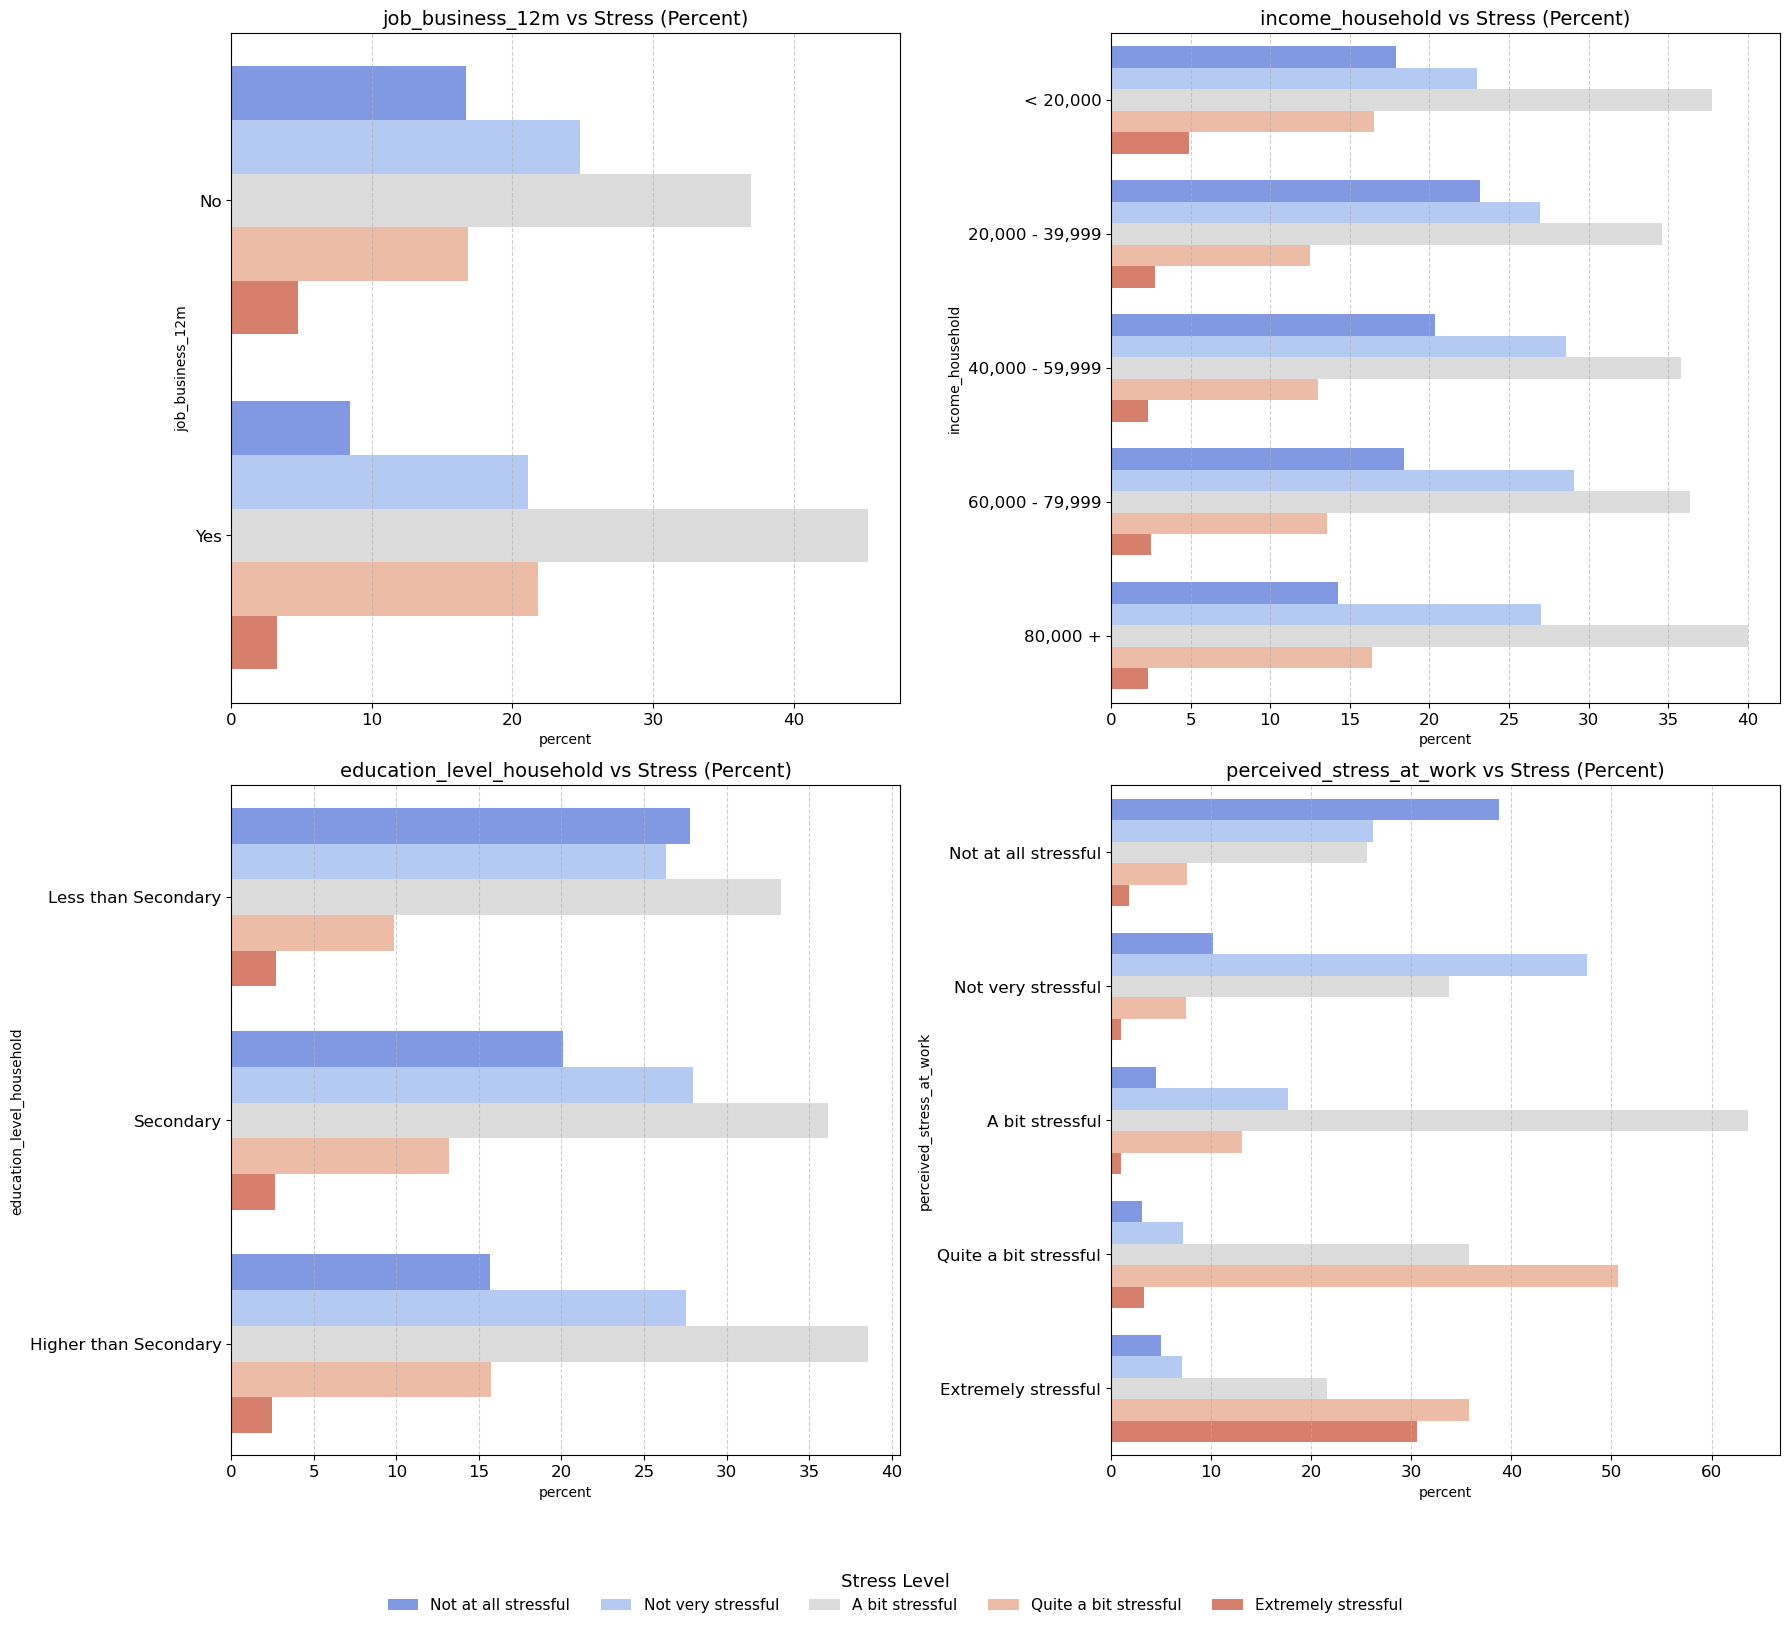

,Variable,Chi-square value,p-value,Cramér’s V,Interpretation,Excluded count
0,perceived_stress_at_work,23044.641,<0.001,0.367,Strong,65028
1,job_business_12m,825.813,<0.001,0.125,Moderate,54973
2,education_level_household,1089.037,<0.001,0.073,Weak,5805
3,income_household,1285.791,<0.001,0.055,Weak,2315


In [40]:
analyze_and_plot(cchs_fin)

Respondents who worked in the past 12 months report higher overall stress than those who did not. Among them, “A bit stressful” and “Quite a bit stressful” are the most common categories, while non-working individuals more often report lower stress levels.

Those in the lowest income bracket (< 20,000) have the highest rates of severe stress. Interestingly, respondents in the 20,000 – 39,999 range more frequently report the lowest stress levels. As income increases beyond this point, the percentage of “Not at all stressful” responses steadily declines, while “Quite a bit stressful” becomes more common.

Respondents from households with less than secondary education tend to perceive life as less stressful than those with higher educational attainment. This trend holds across three out of five stress categories.

*Perceived stress at work* shows the clearest pattern: those who rate their work as “Extremely stressful” are far more likely to report high life stress. Conversely, those with little or no work stress cluster in the lowest stress categories. This may indicate a direct connection between work-related stress and perceived life stress.

**Association summary:**

- The strongest association is observed between **perceived life stress and stress at work** (Cramér’s V = 0.367), indicating a **strong relationship** — unsurprising, as workplace stress is a major driver of overall stress. Notably, a large number of records (65,028) were excluded as mostly a "Valid skip" for people under the age of 18 and 65 and older.

- **Job or business activity in the past 12 months** also shows a **moderate association** (V = 0.125), reinforcing that employment status is related to stress levels.

- **Household education** and **income** show **weaker associations** (V = 0.073 and 0.055, respectively), though both are statistically significant. This suggests that while socioeconomic background contributes to stress, its impact is less pronounced than direct job-related factors.

Overall, job-related variables show stronger ties to stress than general socioeconomic indicators.

#### Social Factors

In this section, I explore social factors that may influence perceived life stress: marital status (already analyzed and included here for comparison), household size, and sense of community belonging. Together, these variables reflect different aspects of socialization — from the number of people sharing one’s living space to the feeling of connection with a local group, such as neighbors or people with shared interests.

The analysis follows the same approach used in previous sections.

In [44]:
print_value_counts_with_percent(cchs_soc)


marital_status value counts (absolute and %):


,Count,Percent
marital_status,,
Married/Common-law,55684,51.6
"Widowed/Divorced/Separated/Single, never married",45290,42.0
Valid skip,6478,6.0
Not stated,371,0.3



household_size value counts (absolute and %):


,Count,Percent
household_size,,
Household size 2 or more,73590,68.3
Lives alone (household size=1),33715,31.3
Not stated,518,0.5



community_belonging value counts (absolute and %):


,Count,Percent
community_belonging,,
Somewhat strong,53020,49.2
Very strong,23078,21.4
Somewhat weak,20352,18.9
Very weak,6744,6.3
Not stated,3491,3.2
Don't know,1054,1.0
Refusal,84,0.1


Skipping marital status, I will start with a household size. More than **2/3** of population **share the household** with other people, and less than **1/3 live alone**. 

**21.4%** of respondents report a **very strong** feeling of belonging to the community, and **49.2%** state it as **"Somewhat strong"**. Contrary, **"Somewhat weak"** and **"Very weak"** are true for **18.9%** and **6.3%**, respectively.

Preparation of the data for plotting by shortening category names and explicitly ordering selected categories.

In [47]:
# Set a rename map
rename_map = {
    'marital_status': {
        'Widowed/Divorced/Separated/Single, never married': 'Non-married',
        'Married/Common-law': 'Married'
    },
    'household_size': {
        'Household size 2 or more': '2 or more',
        'Lives alone (household size=1)': 'Lives alone',
    }
}

# Rename categories
cchs_soc = rename_categories_multiple(cchs_soc, rename_map)


# Set ordinal_orders
ordinal_orders = {
    'household_size': ['Lives alone', '2 or more'],
    'community_belonging': ['Very weak', 'Somewhat weak', 'Somewhat strong', 'Very strong']
}

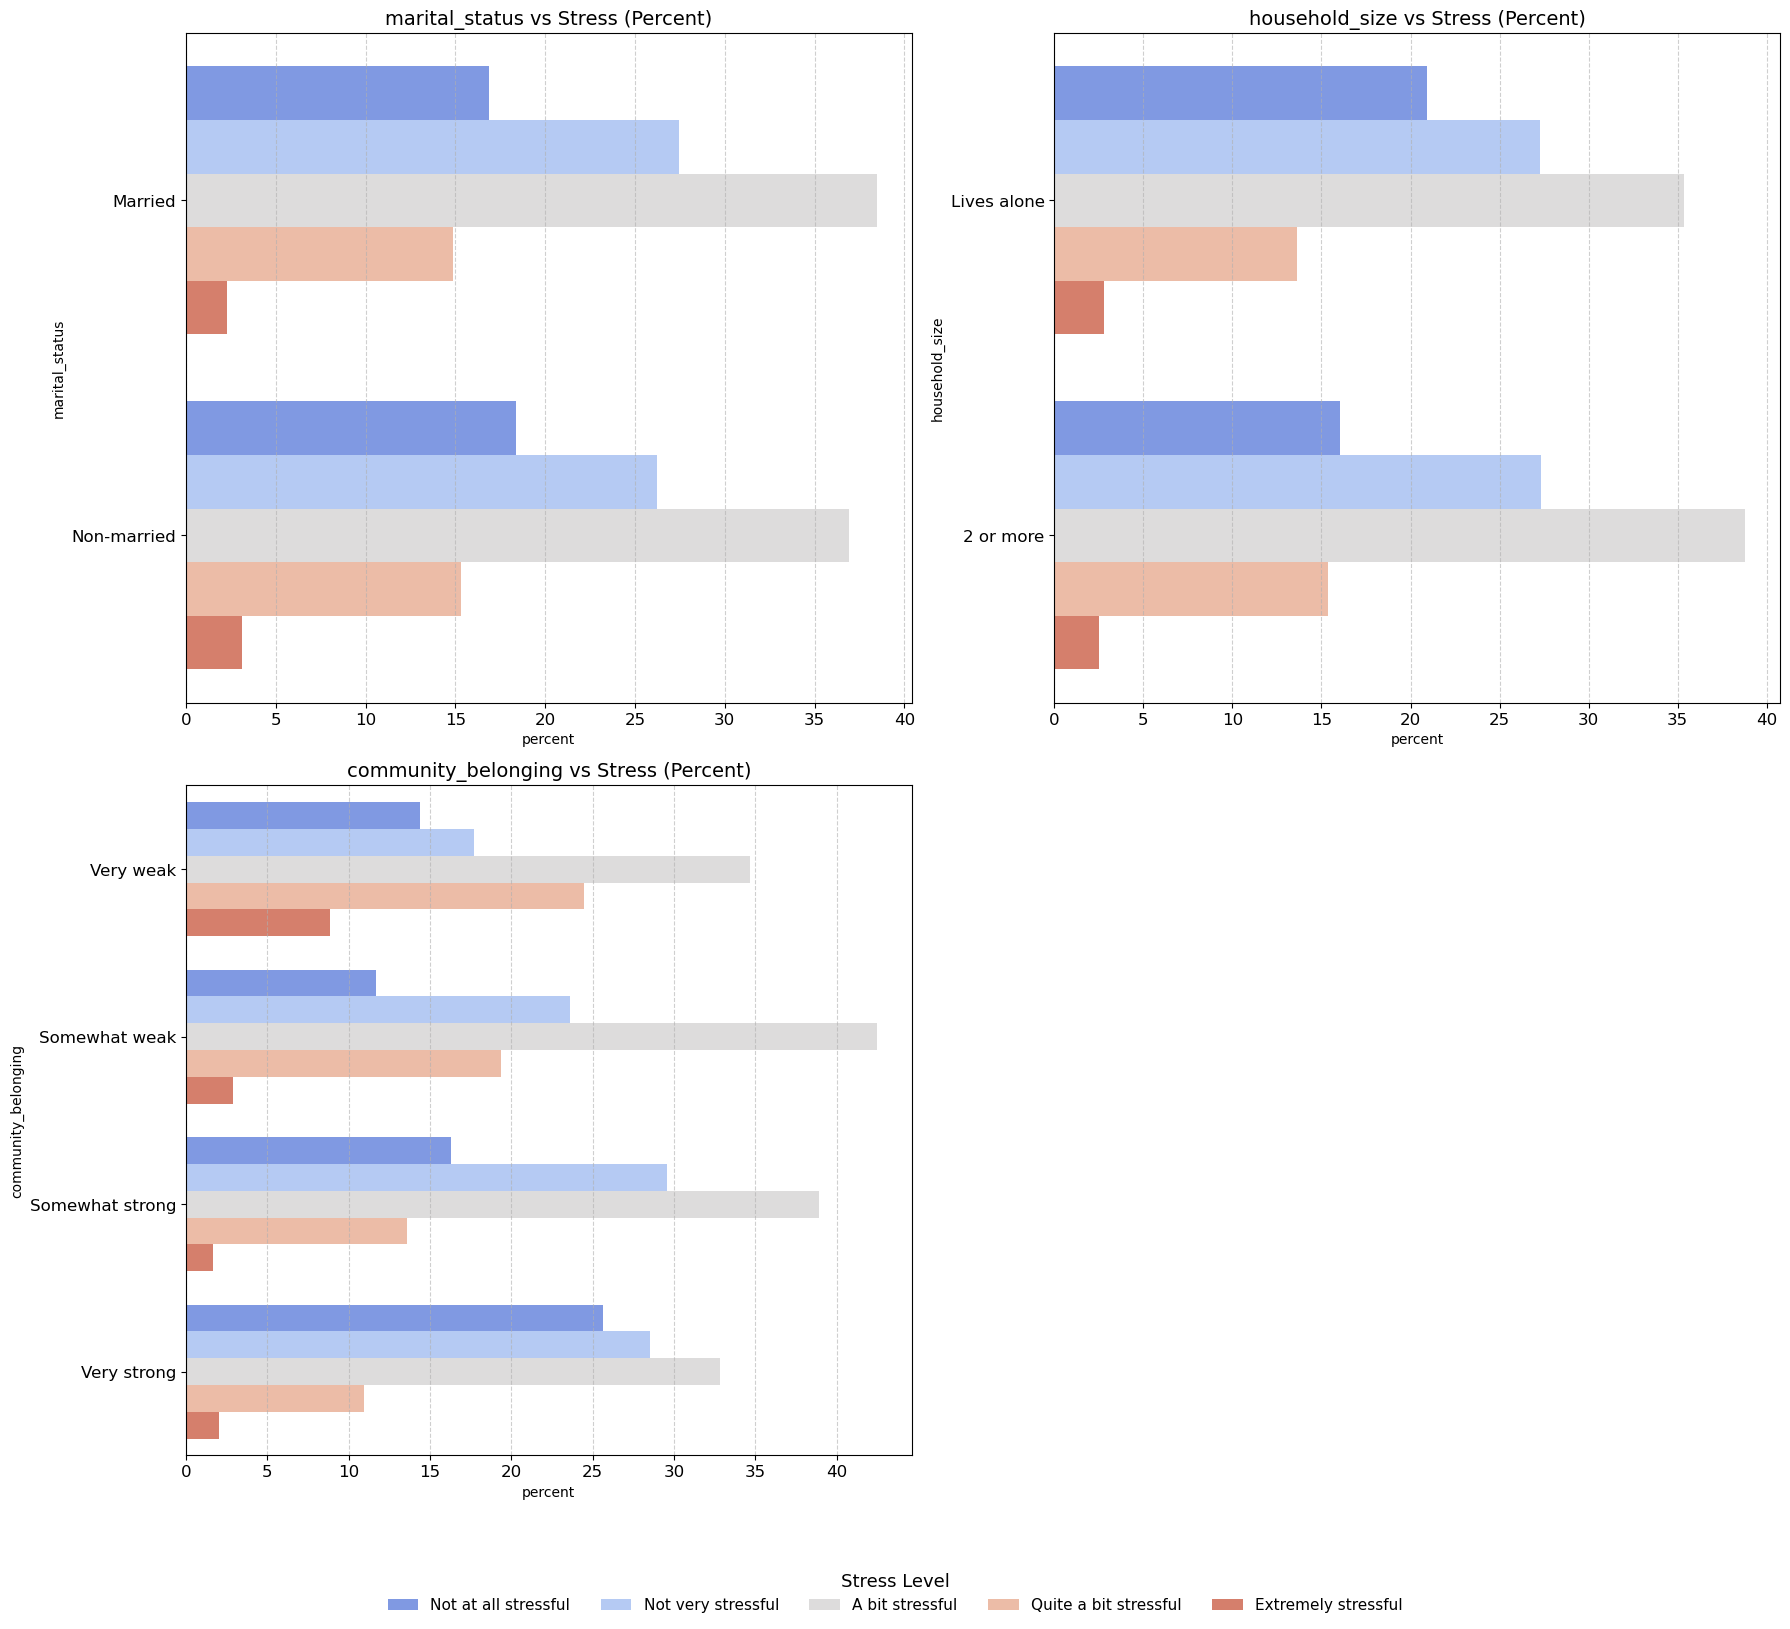

,Variable,Chi-square value,p-value,Cramér’s V,Interpretation,Excluded count
0,community_belonging,4358.889,<0.001,0.118,Moderate,4629
1,household_size,445.479,<0.001,0.064,Weak,518
2,marital_status,130.258,<0.001,0.035,Weak,6849


In [48]:
analyze_and_plot(cchs_soc)

The barplot of household size vs. stress suggests that people who live alone report slightly lower stress levels overall. The proportion selecting **“Not at all stressful”** is about **5% higher** compared to those living with others.

Interestingly, the stress distribution among **married individuals** and those who **live with others** is nearly identical, suggesting that marriage itself may not add a distinct effect beyond cohabitation.

Respondents with **very weak community belonging** report notably higher levels of extreme stress. Conversely, those with **strong or very strong community ties** are more likely to describe life as **"Not at all stressful"**. This trend appears across 3 out of 5 stress categories, indicating that a stronger community connection is associated with lower perceived stress.

**Associations Summary:**

- The strongest association is observed between **community belonging** and perceived stress (Cramér’s V = 0.118), indicating a **moderate relationship**. This supports the visual pattern: stronger community ties are linked to lower stress.

- **Household size** shows a **weak association** (V = 0.064), yet the effect is statistically significant. People living alone appear slightly more likely to report low stress.

- **Marital status** also has a **weak association** (V = 0.035), suggesting limited impact on stress levels as it was observed earlier.

**Overall**, community belonging stands out as the most relevant social factor associated with stress, while household structure and marital status play smaller roles.


#### Cultural and Ethnic Identity

The relationship between cultural and ethnic identity and perceived life stress touches on the broader issue of **social inclusion**. In many countries, individuals with a migration background often face challenges integrating into a new culture. Cultural differences and experiences of xenophobia can contribute to elevated stress levels in these groups.

People with an **aboriginal identity**, while not having a migration background, may still experience differential treatment within society. This section examines the historical and ongoing issues of **social inclusion**, and explores whether stress levels today are associated with cultural background or ethnicity.

In [52]:
print_value_counts_with_percent(cchs_ident)


aboriginal_ident value counts (absolute and %):


,Count,Percent
aboriginal_ident,,
No,100493,93.2
Yes,4002,3.7
Not stated,2847,2.6
Don't know,428,0.4
Refusal,53,0.0



immigrant_flag value counts (absolute and %):


,Count,Percent
immigrant_flag,,
Non-immigrant (Canadian born),88296,81.9
Landed immigrant / non-permanent resident,17369,16.1
Not stated,2158,2.0



visible_minority value counts (absolute and %):


,Count,Percent
visible_minority,,
Not a visible minority,94635,87.8
Visible minority,10385,9.6
Not stated,2803,2.6


The majority of respondents identify as **non-Indigenous (93.2%)**, **Canadian-born (81.9%)**, and **not part of a visible minority (87.8%)**. People identifying as **Indigenous**, **immigrants**, or **visible minorities** represent smaller portions of the sample (under 17% each), which may limit subgroup comparisons but still allows for observing general trends in stress perception across cultural and ethnic backgrounds.

In [54]:
# Set a rename map
rename_map = {
    'immigrant_flag': {
        'Non-immigrant (Canadian born)': 'Canadian born',
        'Landed immigrant / non-permanent resident': 'Immigrated'
    }
}

# Rename categories
cchs_ident = rename_categories_multiple(cchs_ident, rename_map)

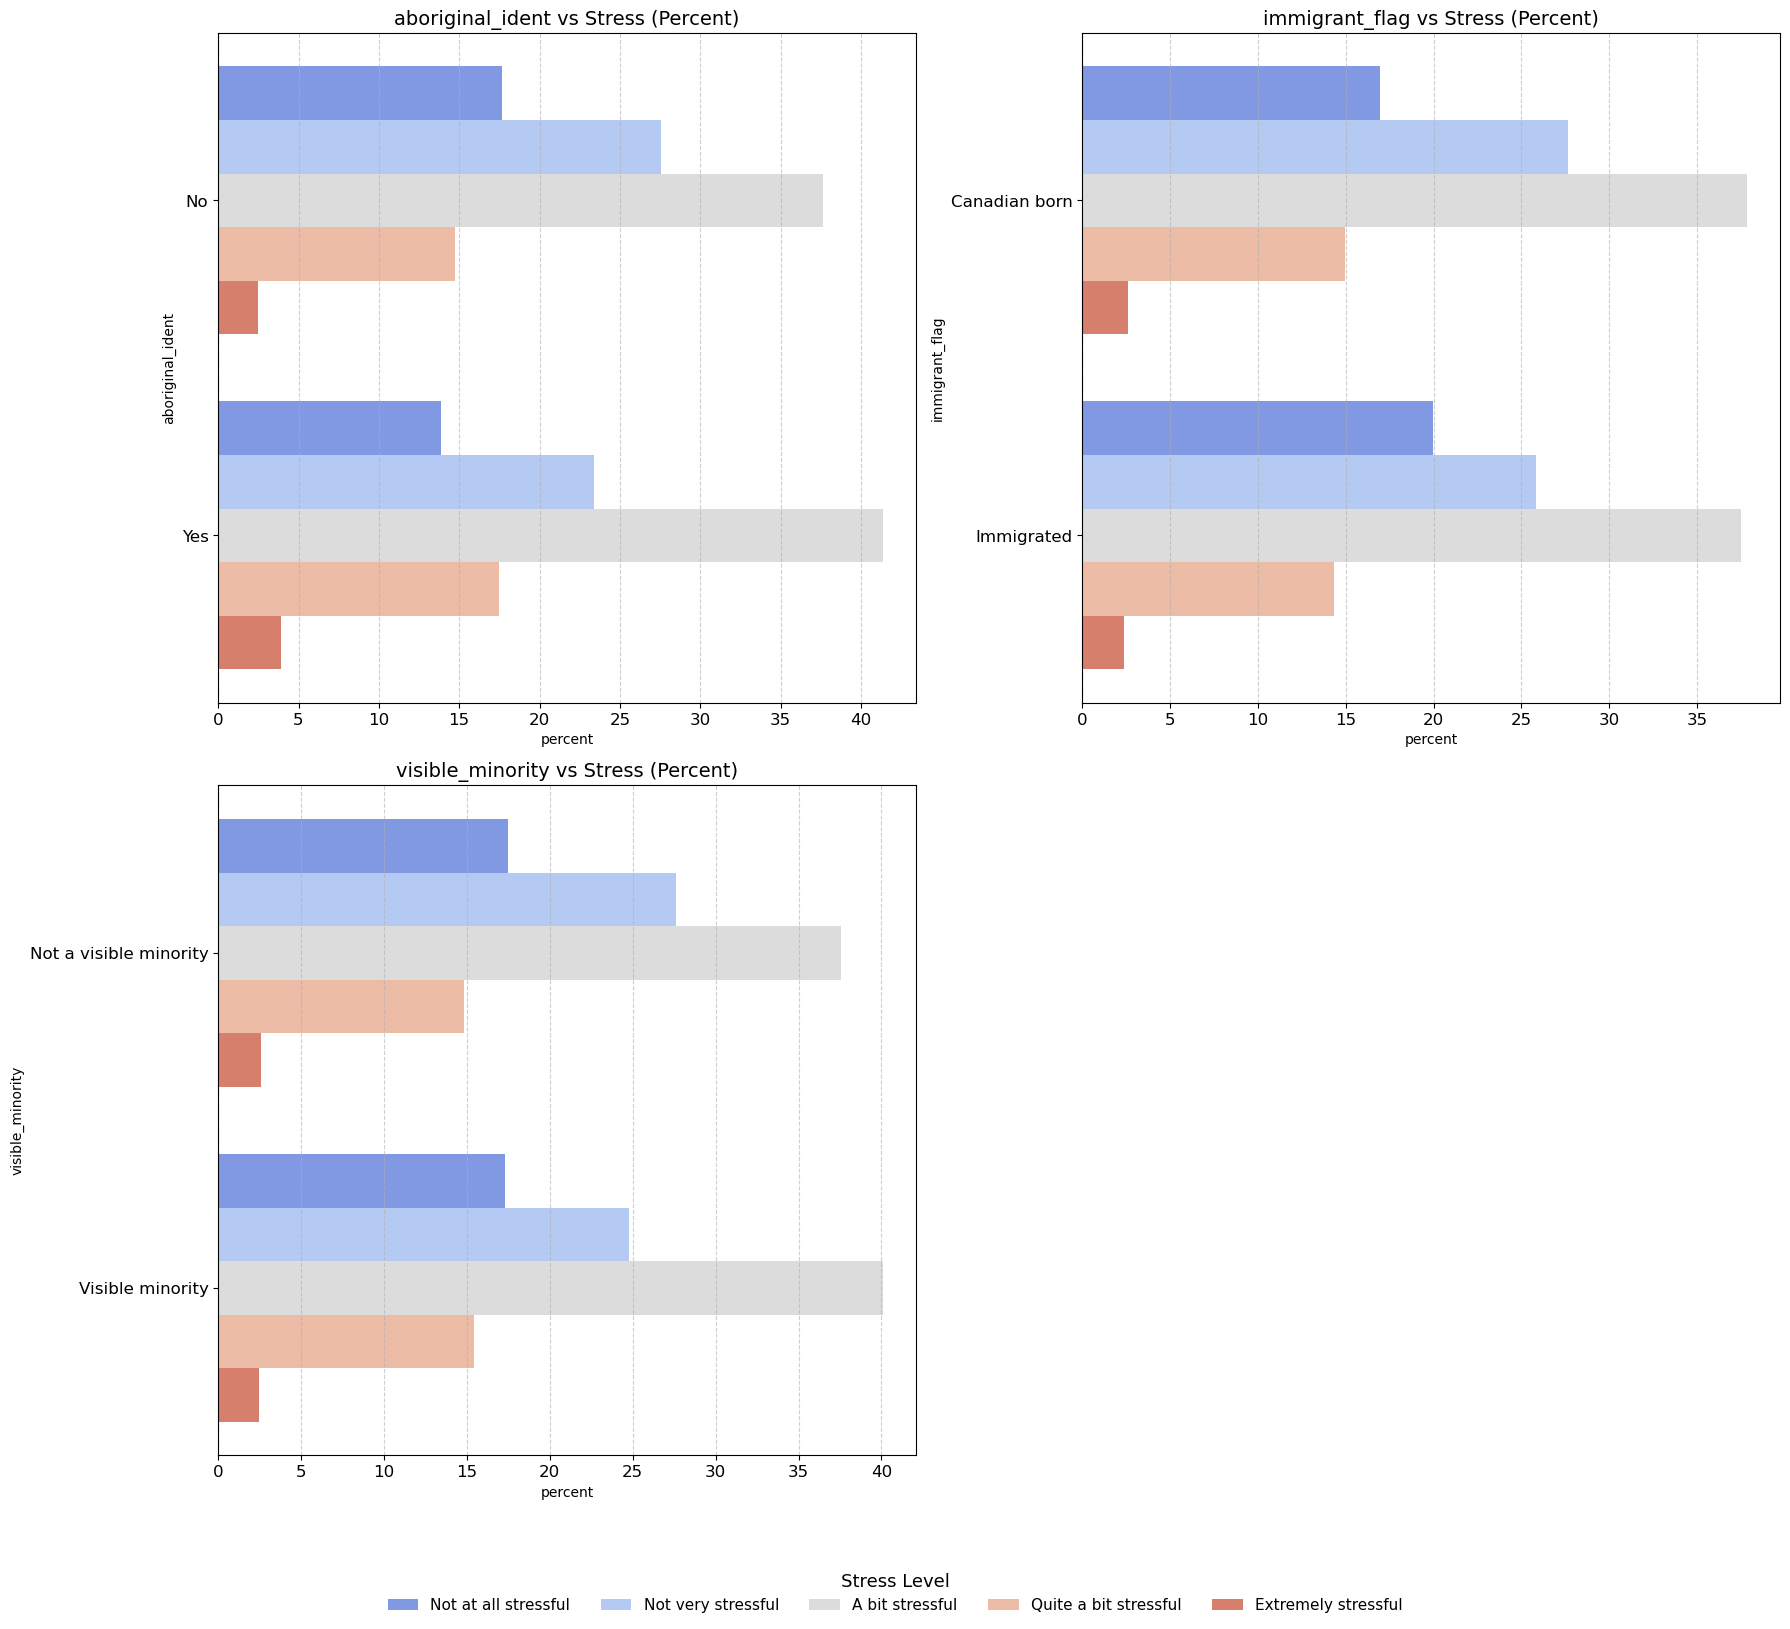

,Variable,Chi-square value,p-value,Cramér’s V,Interpretation,Excluded count
0,aboriginal_ident,119.970,<0.001,0.033,Weak,3328
1,immigrant_flag,96.962,<0.001,0.030,Weak,2158
2,visible_minority,47.523,<0.001,0.020,Weak,2803


In [55]:
analyze_and_plot(cchs_ident)

According to the barplots, people with an **aboriginal identity** report higher levels of life stress compared to those without such identity. This trend is consistent across all stress categories and may reflect long-standing issues of social exclusion and marginalization.

Interestingly, respondents who **immigrated to Canada** report slightly lower levels of perceived stress than those who are **Canadian-born**. This could suggest potential resilience or differing expectations and coping mechanisms among immigrant populations.

Individuals who can be identified as a **visible minority** show a subtle shift toward higher stress: they are more represented in the “A bit stressful” category and less so in “Not very stressful.”.

While these identity-related factors show some meaningful patterns in the visual analysis, their statistical associations with stress are relatively weak.

**Associations Summary:**

All three variables related to cultural and ethnic identity show **statistically significant but weak associations** with perceived life stress:

- **Aboriginal identity** has the strongest association among the three (Cramér’s V = 0.033), though the effect is still weak.  
- **Immigration status** shows a slightly lower association (V = 0.030), and  
- **Visible minority status** has the weakest (V = 0.020).  

These low values suggest that while identity-related factors are linked to perceived stress, the relationships are subtle, possibly influenced by other unmeasured structural or contextual variables.

#### Geographic Factors

The CCHS dataset includes two main geographic variables: **province** and **health region**. While provincial boundaries are well-established administrative units, **health region boundaries** are defined by provincial and territorial health authorities and are more subject to change over time.

For clarity and consistency, the analysis of perceived life stress in this section will focus on the **provincial level**. Provinces offer a more stable basis for comparison, align better with national statistics, and allow for clearer geographic interpretation across Canada. 

While this level of aggregation may generalize some regional variation, it allows to keep a practical balance between granularity and interpretability within the scope of this project.

In [59]:
cchs_reg.province.value_counts()

province
35    30431
24    19080
59    12119
48    11577
46     6440
47     6205
12     5632
13     5355
10     5320
11     4142
60     1522
Name: count, dtype: int64

The provinces and territories in the dataset are listed by their **Standard Geographical Classification (SGC)** codes. Notably, the codes **61 (Northwest Territories)** and **62 (Nunavut)** are absent from the list. According to the CCHS documentation, the code **60** does not refer to Yukon alone, but rather to **all three territories combined**: Yukon, Northwest Territories, and Nunavut.

To improve readability, I will now add a new column to the subset that maps these codes to their corresponding **province or territory names**.

In [61]:
province_map = {
    10: "Newfoundland and Labrador",
    11: "Prince Edward Island",
    12: "Nova Scotia",
    13: "New Brunswick",
    24: "Quebec",
    35: "Ontario",
    46: "Manitoba",
    47: "Saskatchewan",
    48: "Alberta",
    59: "British Columbia",
    60: "Territories (YT/NT/NU)"
}

cchs_reg = cchs_reg.copy()
cchs_reg['province_name'] = cchs_reg['province'].replace(province_map)

cchs_reg.head()

,province,perceived_life_stress,province_name
0,47,Not very stressful,Saskatchewan
1,47,A bit stressful,Saskatchewan
2,59,A bit stressful,British Columbia
3,13,A bit stressful,New Brunswick
4,46,Quite a bit stressful,Manitoba


Next, I’ll check the value counts and percentages to see how respondents are distributed across provinces and territories.

In [63]:
print_value_counts_with_percent(cchs_reg)


province value counts (absolute and %):


,Count,Percent
province,,
35,30431,28.2
24,19080,17.7
59,12119,11.2
48,11577,10.7
46,6440,6.0
47,6205,5.8
12,5632,5.2
13,5355,5.0
10,5320,4.9



province_name value counts (absolute and %):


,Count,Percent
province_name,,
Ontario,30431,28.2
Quebec,19080,17.7
British Columbia,12119,11.2
Alberta,11577,10.7
Manitoba,6440,6.0
Saskatchewan,6205,5.8
Nova Scotia,5632,5.2
New Brunswick,5355,5.0
Newfoundland and Labrador,5320,4.9


The sample is largely concentrated in **Ontario (28.2%)**, **Quebec (17.7%)**, and **British Columbia (11.2%)**, which reflects Canada's population distribution. Smaller provinces and the **Territories (1.4%)** are less represented, which may affect the reliability of region-specific insights in those areas.

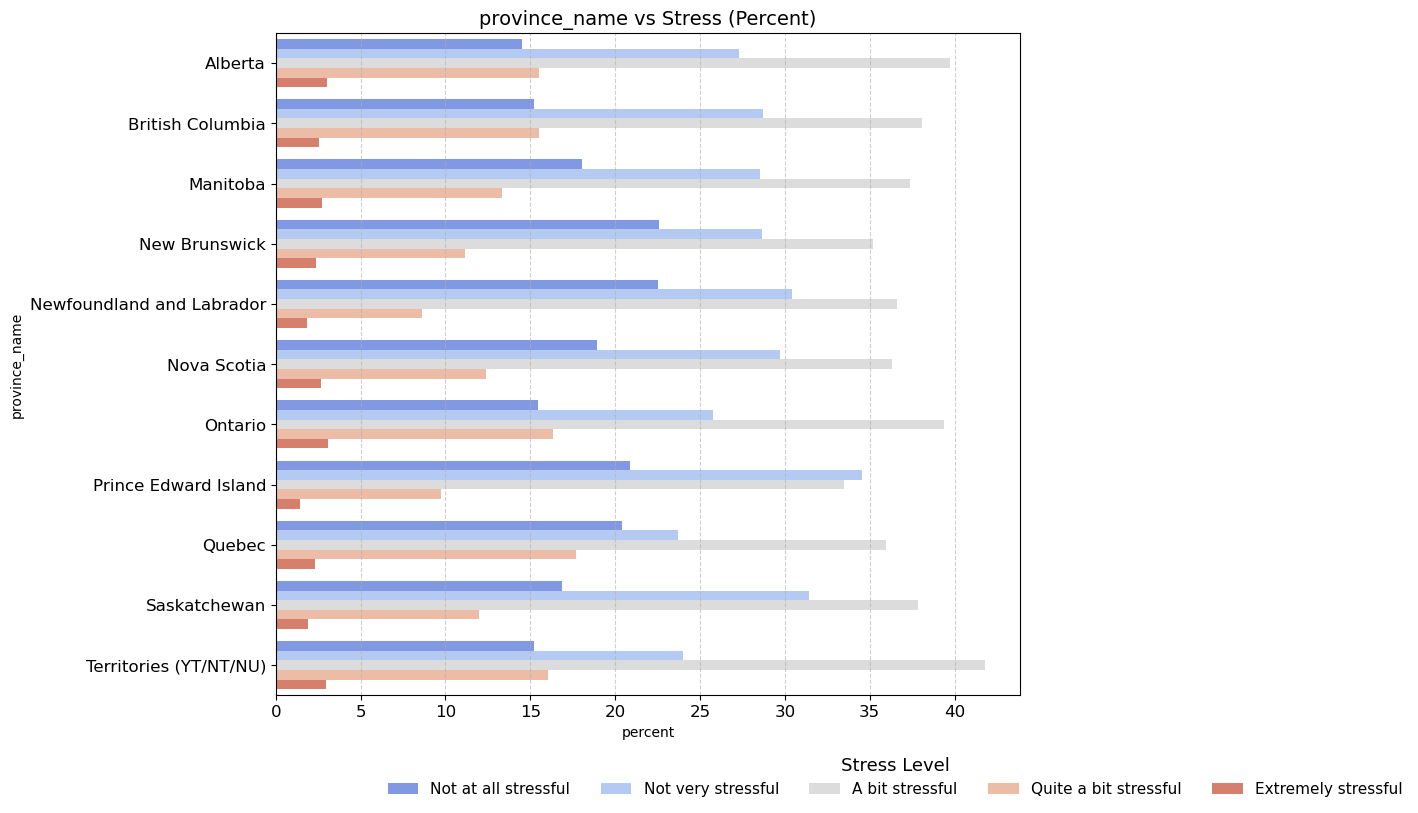

,Variable,Chi-square value,p-value,Cramér’s V,Interpretation,Excluded count
0,province_name,1410.893,<0.001,0.056,Weak,0


In [65]:
analyze_and_plot(cchs_reg, var_list=['province_name'])

One can see that the perception of stress differs across the provinces and territories of Canada. For example, **Ontario**, **Alberta**, and the **Territories** report higher levels of stress, while **New Brunswick**, **Newfoundland and Labrador**, and **Prince Edward Island** show lower levels.

In **Prince Edward Island**, the response *"Not very stressful"* is more frequent than *"A bit stressful"*, which stands out as an unusual pattern compared to other regions.

The association between **province** and perceived life stress is statistically significant but **weak** (Cramér’s V = 0.056). This indicates a modest link between geographic location and stress perception.

To visualize perceived life stress across Canada more clearly, I will use GeoPandas along with a boundary shapefile obtained from Statistics Canada.

dtype('int64')

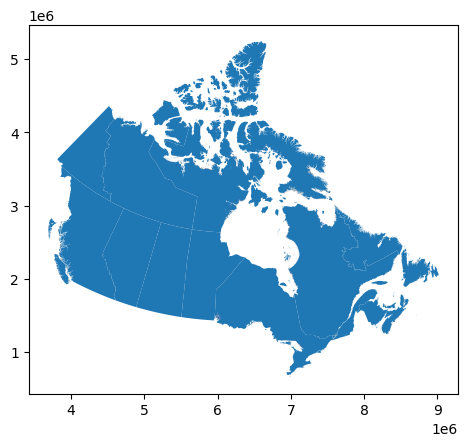

In [67]:
# Read the shape file
gdf = gpd.read_file("/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/data/lpr_000b16a_e/lpr_000b16a_e.shp")

# List province IDs and plot the map preview
gdf['PRUID'] = gdf['PRUID'].astype(int)
gdf.plot()
gdf.PRUID.dtypes

The shapefile above shows the standard division of the three territories. However, since the CCHS dataset aggregates them under a single code, I will edit the shapefile and merge their geometries into one unified **Territories** region.

province_group
10    1
11    1
12    1
13    1
24    1
35    1
46    1
47    1
48    1
59    1
60    1
Name: count, dtype: int64


<Axes: >

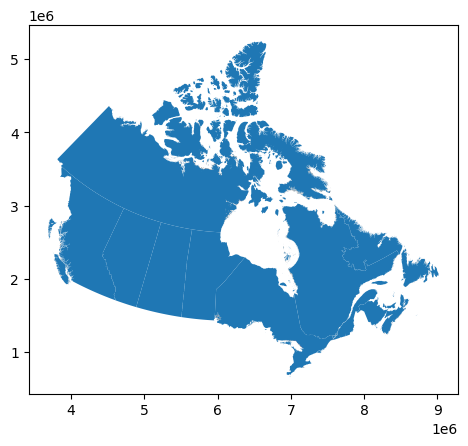

In [69]:
# Replace 61 and 62 with 60 in PRUID
gdf['province_group'] = gdf['PRUID'].replace({61: 60, 62: 60})

# Group by province_group and dissolve to merge geometries
gdf_grouped = gdf.dissolve(by='province_group', as_index=False)

# Check counts and plot
print(gdf_grouped['province_group'].value_counts())
gdf_grouped.plot()

Next, I will merge the CCHS subset with the geographic data.

In [71]:
# Rename the column
gdf_grouped.rename(columns={'province_group': 'province'}, inplace=True)

# Merge data with geometry
cchs_reg_geo = pd.merge(cchs_reg, gdf_grouped, on='province', how='left')
cchs_reg_geo.head(1)

,province,perceived_life_stress,province_name,geometry,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR
0,47,Not very stressful,Saskatchewan,"POLYGON ((5248633.914 2767057.263, 5249285.64 ...",47,Saskatchewan,Saskatchewan,Saskatchewan,Sask.,Sask.


To visualize regional stress levels, I will map the stress categories to numeric values (1–5), calculate the average stress score per province, merge this with geographic data, and plot the results using a choropleth map.

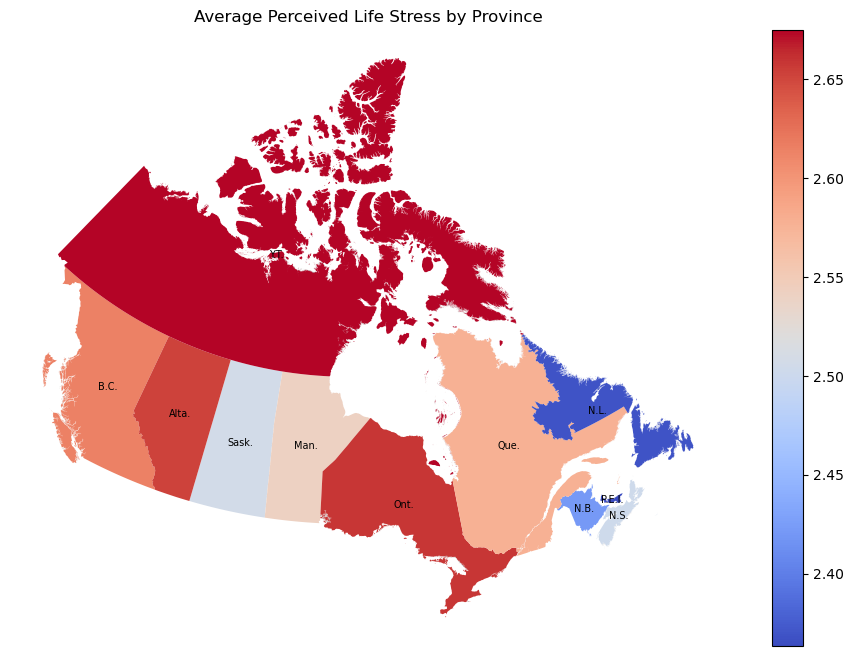

,province_name,stress_num
0,Alberta,2.651896
1,British Columbia,2.614242
2,Manitoba,2.541460
3,New Brunswick,2.420915
4,Newfoundland and Labrador,2.368985
5,Nova Scotia,2.502663
6,Ontario,2.658342
7,Prince Edward Island,2.363351
8,Quebec,2.577411
9,Saskatchewan,2.506366


In [73]:
# 1. Map stress levels to numeric scores
stress_order = [
    'Not at all stressful',
    'Not very stressful',
    'A bit stressful',
    'Quite a bit stressful',
    'Extremely stressful'
]
stress_map = {k: v+1 for v, k in enumerate(stress_order)}
cchs_reg_geo['stress_num'] = cchs_reg_geo['perceived_life_stress'].map(stress_map)

# 2. Calculate mean stress by province
mean_stress = cchs_reg_geo.groupby('province_name')['stress_num'].mean().reset_index()

# 3. Merge mean stress back to GeoDataFrame (unique polygons by province_name)
gdf_provinces = cchs_reg_geo.drop_duplicates(subset='province_name')[['province_name', 'geometry', 'PREABBR']]
gdf_provinces = gdf_provinces.merge(mean_stress, on='province_name')

# Make sure gdf_provinces is a GeoDataFrame
gdf_provinces = gpd.GeoDataFrame(gdf_provinces, geometry='geometry')

fig, ax = plt.subplots(figsize=(12, 8))

gdf_provinces.plot(
    column='stress_num',
    cmap='coolwarm',
    legend=True,
    ax=ax
)

ax.set_title('Average Perceived Life Stress by Province')
ax.axis('off')

# Add text labels (province_name and mean stress)
for idx, row in gdf_provinces.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, f"{row['PREABBR']}",
            ha='center', va='center', fontsize=7)

plt.show()
mean_stress

The table and map above show the **average perceived life stress** by province and all the territories, based on numeric values from 1 (*Not at all stressful*) to 5 (*Extremely stressful*).

The **highest average stress levels** are reported in the **Territories (2.67)**, **Ontario (2.66)**, and **Alberta (2.65)**. In contrast, the **lowest stress levels** are observed in **Prince Edward Island (2.36)** and **Newfoundland and Labrador (2.37)**.

These differences highlight modest regional variation in perceived stress across Canada. It is important to note that, while variations exist, the province or territory level provides only a broad overview.

Exploring stress perception at a finer geographic scale — such as health regions or communities — could be the focus of a separate project. Although this would likely require merging CCHS data with other datasets and working extensively with boundary shapefiles, which can be challenging due to inconsistent coding and shifting boundaries, it would enable a more detailed examination of stress patterns and their relationships.

### 3. Exploratory Data Analysis (EDA): Health Factors

Health is the central theme of the CCHS dataset, with the majority of questions focused on different aspects of healthcare and well-being. Designed to inform improvements in Canada’s healthcare system, the survey supports highly detailed health research. In this project, the scope is more general, with the focus on perceived life stress. For further analysis, I will explore its relationship with four selected variables: perceived general health, perceived mental health, and consultation with a mental health professional.
The underlying hypothesis is that higher levels of perceived stress are associated with poorer mental health and lower life satisfaction.

In [77]:
# Set ordinal_orders
ordinal_orders = {
    'perceived_health': ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'],
    'perceived_mh': ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
}

In [78]:
print_value_counts_with_percent(cchs_health)


perceived_health value counts (absolute and %):


,Count,Percent
perceived_health,,
Very good,38994,36.2
Good,31511,29.2
Excellent,21146,19.6
Fair,11665,10.8
Poor,4352,4.0
Don't know,142,0.1
Refusal,13,0.0



perceived_mh value counts (absolute and %):


,Count,Percent
perceived_mh,,
Very good,38727,35.9
Excellent,30312,28.1
Good,26447,24.5
Fair,6924,6.4
Not stated,3491,3.2
Poor,1765,1.6
Don't know,124,0.1
Refusal,33,0.0



consulted_mh_prof value counts (absolute and %):


,Count,Percent
consulted_mh_prof,,
No,75623,70.1
Valid skip,15702,14.6
Yes,13539,12.6
Not stated,2812,2.6
Refusal,76,0.1
Don't know,71,0.1


The majority of respondents rate their **general** and **mental health** as *Good*, *Very Good*, or *Excellent*, with only small proportions reporting *Fair* or *Poor* health. Around **70%** have **not consulted** a mental health professional, though a notable **14.6%** fall under "Valid skip".

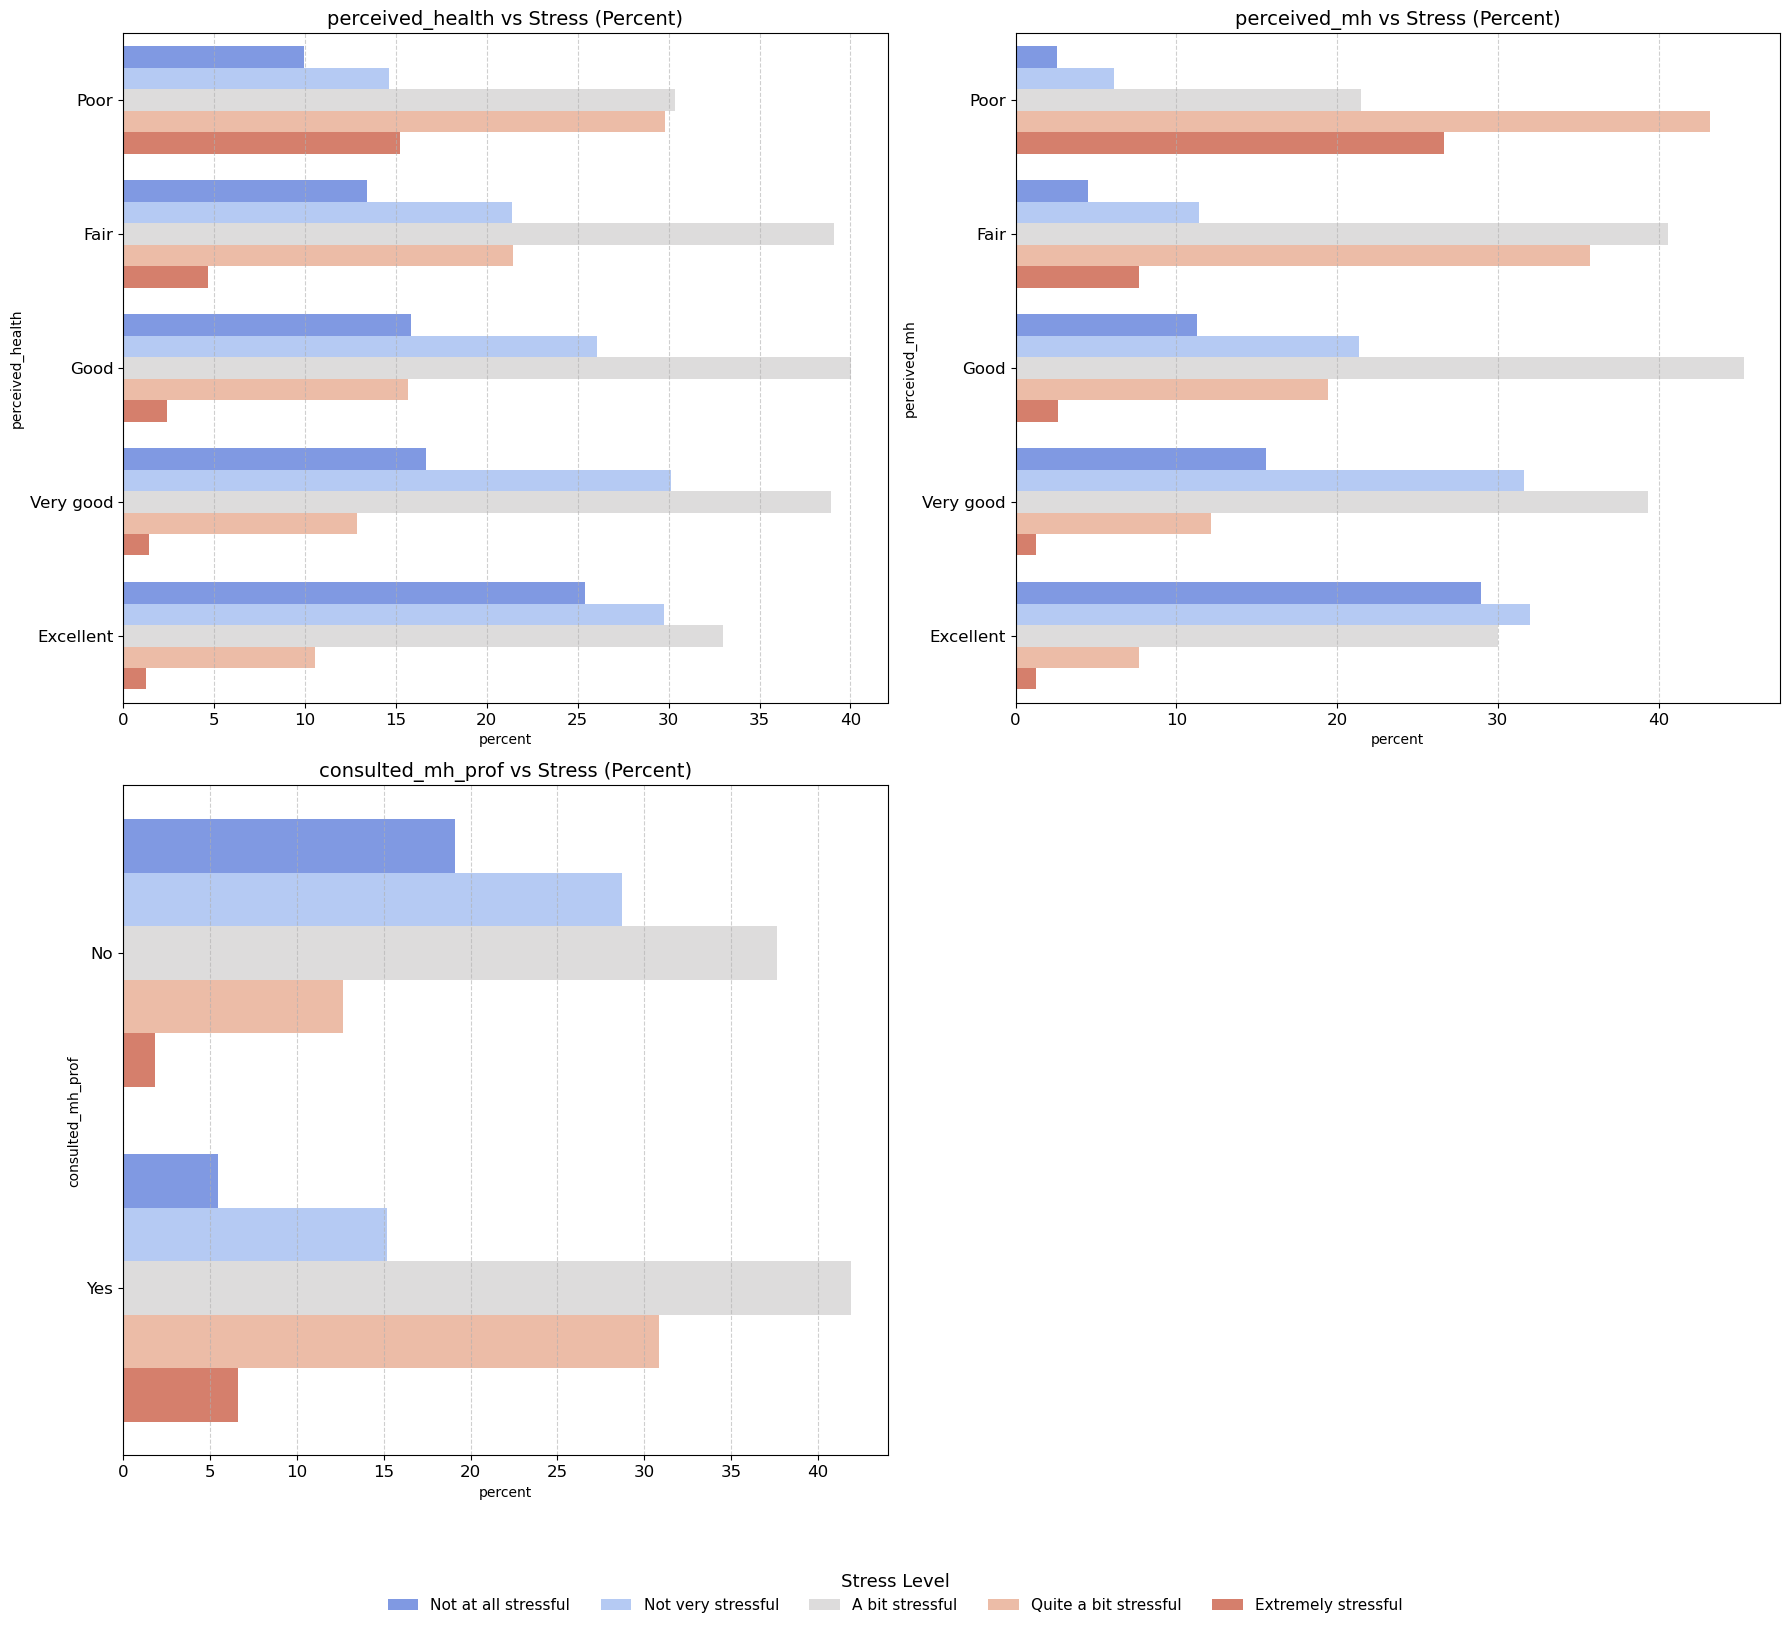

,Variable,Chi-square value,p-value,Cramér’s V,Interpretation,Excluded count
0,consulted_mh_prof,5550.664,<0.001,0.249,Moderate,18661
1,perceived_mh,16603.300,<0.001,0.200,Moderate,3648
2,perceived_health,6510.432,<0.001,0.123,Moderate,155


In [80]:
analyze_and_plot(cchs_health)

Respondents who perceive their health as **"Poor"** are more likely to describe their life as **extremely stressful**, while those reporting **"Excellent"** health most often fall into the **"Not at all stressful"** category. The pattern across the intermediate health levels follows this gradient consistently.

The relationship between **perceived mental health** and stress is even more pronounced, as expected. Respondents with **poor mental health** show significantly higher rates of *"Extremely stressful"* and *"Quite a bit stressful"*, with the latter appearing almost **twice as often as** *"A bit stressful"* — an unusual distribution.

For the binary question about **consultation with a mental health professional**, those who answered **"No"** tend to report lower levels of stress. This could suggest a **reverse relationship**, where higher stress may lead individuals to seek help, rather than consultation reducing stress.

**Association summary:**

All four health-related variables show statistically significant associations with perceived life stress.

- The strongest relationship is found between **consultation with a mental health professional** and stress (Cramér’s V = 0.249), followed by **perceived mental health** (V = 0.200). Both indicate **moderate associations**, highlighting the close link between stress and mental health factors.

- **Perceived general health** also shows a **moderate association** (V = 0.123), reflecting a general pattern where poorer health aligns with higher stress.

### 4. Exploratory Machine Learning

In this section, I shift the focus from treating perceived life stress as a target variable to using it as a predictor. Specifically, I model how stress influences mental health outcomes and mental health service use, while controlling for key demographic factors — age group and sex — which are known to affect both stress and health behaviors.

To prepare the data for modeling, I will first filter and encode ordinal features — including stress, mental health, age group, and sex — into numeric form.

In [85]:
# Define mappings for ordinal features
mh_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
mh_map = {k: v + 1 for v, k in enumerate(mh_order)}

stress_order = [
    'Not at all stressful',
    'Not very stressful',
    'A bit stressful',
    'Quite a bit stressful',
    'Extremely stressful'
]
stress_map = {k: v + 1 for v, k in enumerate(stress_order)}

age_order = [
    '12 to 17 years',
    '18 to 34 years',
    '35 to 49 years',
    '50 to 64 years',
    '65 and older'
]
age_map = {k: v + 1 for v, k in enumerate(age_order)}

sex_order = ['Male', 'Female']
sex_map = {k: v + 1 for v, k in enumerate(sex_order)}

# Filter rows with valid categories across all four features
cchs_model_mh = cchs[
    cchs['perceived_mh'].isin(mh_order) &
    cchs['perceived_life_stress'].isin(stress_order) &
    cchs['age_group'].isin(age_order) &
    cchs['sex'].isin(sex_order)
].copy()

# Map to numeric
cchs_model_mh['perceived_mh_num'] = cchs_model_mh['perceived_mh'].map(mh_map)
cchs_model_mh['stress_num'] = cchs_model_mh['perceived_life_stress'].map(stress_map)
cchs_model_mh['age_num'] = cchs_model_mh['age_group'].map(age_map)
cchs_model_mh['sex_num'] = cchs_model_mh['sex'].map(sex_map)

For modelling, I will keep only numeric columns.

In [87]:
columns_to_keep = [
    'perceived_mh_num', 'stress_num',
    'age_num', 'sex_num'
]

cchs_model_mh = cchs_model_mh[columns_to_keep]

In [88]:
cchs_model_mh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104175 entries, 0 to 108251
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   perceived_mh_num  104175 non-null  int64
 1   stress_num        104175 non-null  int64
 2   age_num           104175 non-null  int64
 3   sex_num           104175 non-null  int64
dtypes: int64(4)
memory usage: 4.0 MB


Finally, I will fit the ordinal logistic regression model and display the summary of the results.

In [90]:
# Features: stress_num, age_num, sex_num
X = cchs_model_mh[['stress_num', 'age_num', 'sex_num']]
y = cchs_model_mh['perceived_mh_num']

# Fit
model = OrderedModel(y, X, distr='logit')
res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.269200
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:       perceived_mh_num   Log-Likelihood:            -1.3222e+05
Model:                   OrderedModel   AIC:                         2.645e+05
Method:            Maximum Likelihood   BIC:                         2.645e+05
Date:                Sat, 28 Jun 2025                                         
Time:                        09:10:57                                         
No. Observations:              104175                                         
Df Residuals:                  104168                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

An ordinal logistic regression was fitted to model **perceived mental health** as a function of **perceived life stress**, **age**, and **sex**, using 104,175 observations.

The results show a **strong and statistically significant negative association** between stress and perceived mental health (**coef = -0.63**, *p* < 0.001), indicating that higher stress levels are associated with poorer self-rated mental health.

**Age** also shows a small but significant negative effect (**coef = -0.012**, *p* = 0.006), suggesting that mental health tends to decline slightly with age. The negative coefficient for **sex** (**coef = -0.121**, *p* < 0.001) implies that, in this coding, one sex (Female, encoded as 1) reports worse mental health on average.

The model converged successfully and displays strong overall fit given the large sample size. These findings support the hypothesis that perceived life stress is a strong predictor of mental health status.

In the next step, I will prepare the dataset for logistic regression by filtering to valid categories and mapping ordinal and categorical features—perceived life stress, age group, sex, and mental health professional consultation into numeric values suitable for modeling.

In [93]:
# Define mappings for ordinal features

stress_order = [
    'Not at all stressful',
    'Not very stressful',
    'A bit stressful',
    'Quite a bit stressful',
    'Extremely stressful'
]
stress_map = {k: v + 1 for v, k in enumerate(stress_order)}

age_order = [
    '12 to 17 years',
    '18 to 34 years',
    '35 to 49 years',
    '50 to 64 years',
    '65 and older'
]
age_map = {k: v + 1 for v, k in enumerate(age_order)}

sex_order = ['Male', 'Female']
sex_map = {k: v + 1 for v, k in enumerate(sex_order)}

valid_consulted = ['Yes', 'No']
consult_map = {'Yes': 1, 'No': 0}


# Filter to valid categories for dependent variable
cchs_model_consult = cchs[
    cchs['consulted_mh_prof'].isin(valid_consulted) &
    cchs['perceived_life_stress'].isin(stress_order) &
    cchs['age_group'].isin(age_order) &  # Or your valid_age_groups list
    cchs['sex'].isin(sex_order)
].copy()

# Map dependent variable to binary
cchs_model_consult['consulted_mh_prof_num'] = cchs_model_consult['consulted_mh_prof'].map(consult_map)

# Map independent vars (if not done yet)
cchs_model_consult['stress_num'] = cchs_model_consult['perceived_life_stress'].map(stress_map)
cchs_model_consult['age_num'] = cchs_model_consult['age_group'].map(age_map)  # define age_map as before
cchs_model_consult['sex_num'] = cchs_model_consult['sex'].map(sex_map)

Next, I will specify and fit the logistic regression model using the prepared data.

In [95]:
# Prepare features and target
X = cchs_model_consult[['stress_num', 'age_num', 'sex_num']]
X = sm.add_constant(X)  # adds intercept term
y = cchs_model_consult['consulted_mh_prof_num']

# Fit logistic regression
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.383438
         Iterations 7
                             Logit Regression Results                            
Dep. Variable:     consulted_mh_prof_num   No. Observations:                89162
Model:                             Logit   Df Residuals:                    89158
Method:                              MLE   Df Model:                            3
Date:                   Sat, 28 Jun 2025   Pseudo R-squ.:                 0.09970
Time:                           09:10:58   Log-Likelihood:                -34188.
converged:                          True   LL-Null:                       -37974.
Covariance Type:               nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6780      0.054    -68.557      0.000      -3.783      -3.573
stres

A binary logistic regression model was used to predict whether respondents had **consulted a mental health professional**, based on **perceived life stress**, **age**, and **sex**, using a sample of 89,162 observations.

The results show that **stress is a strong and significant predictor** of consultation behavior (**coef = 0.65**, *p* < 0.001): as stress increases, the likelihood of seeking mental health support also increases.

**Age** has a significant **negative effect** (**coef = -0.27**, *p* < 0.001), indicating that younger individuals are more likely to seek help. Meanwhile, **sex** shows a **positive effect** (**coef = 0.67**, *p* < 0.001), suggesting one sex (Female, encoded as 1) is more likely to have consulted a mental health professional.

The model converged quickly and demonstrates meaningful explanatory power (*Pseudo R² = 0.0997*), highlighting the importance of stress and demographic factors in predicting help-seeking behavior.

### Summary

This project analyzed perceived life stress using Canadian Community Health Survey data, identifying key demographic, socioeconomic, social, cultural, and health factors linked to stress. Work-related stress and recent job or business activity showed the strongest associations, while income, education, and cultural identity had weaker but significant effects. Geographic differences were modest at the provincial level, though there is potential for more detailed research using health regions and census subdivisions.

Apart from that, exploratory analysis importantly revealed that stress levels correlate with various health factors, including general and mental health, as well as mental health consultations.

Predictive models confirmed that higher perceived stress strongly relates to poorer mental health and an increased likelihood of consulting mental health professionals, even after adjusting for age and sex.

These findings highlight the complex, multifaceted nature of stress and its impact on mental health, pointing to opportunities for targeted public health interventions and further study.

A concise visual presentation of these findings will follow in the form of interactive Tableau dashboards. presentation of findings will follow in Tableau dashboards.

##### Saving Files

In [100]:
cchs.to_csv('/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/cchs_pres.csv')

In [101]:
gdf_provinces.to_file("canada_provinces.shp")

/var/folders/9k/pzdvp6qx6pl_1mqpl62zyg4h0000gn/T/ipykernel_62039/1505023507.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_provinces.to_file("canada_provinces.shp")
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'province_name' to 'province_n'
  ogr_write(


In [102]:
# Get coefficient estimates
params = res.params
conf = res.conf_int()
conf.columns = ['CI_lower', 'CI_upper']

# Combine into a single DataFrame
summary_df = pd.concat([
    params.rename('Coefficient'),
    res.bse.rename('Std_Err'),
    res.pvalues.rename('P_Value'),
    conf
], axis=1)

# Reset index and rename
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Variable'}, inplace=True)

summary_df.to_csv('/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/Ordered_sum_Tableau.csv')

In [103]:
# Get coefficients and statistics
summary_df = model.summary2().tables[1].copy()  # Table 1 contains the coefficient summary

# Clean up and rename columns
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Variable'}, inplace=True)

# Export
summary_df.to_csv('/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/logit_sum_Tableau.csv', index=False)

In [104]:
cchs_reg.to_csv('/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/cchs_reg.csv')

In [105]:
# Get raw counts
counts = cchs_reg_geo.groupby(['province_name', 'perceived_life_stress']).size().unstack(fill_value=0)

# Convert to percentages (row-wise, by province)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Reset index to make province_name a column again
percentages = percentages.reset_index()

percentages.to_csv('/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/cchs_reg_percentages.csv')

In [106]:
# Calculate the average percentages for Canada
canada_row = percentages.mean(numeric_only=True).to_frame().T
canada_row['province_name'] = 'Canada'

# Append the Canada row to the dataframe
percentages_with_canada = pd.concat([percentages, canada_row], ignore_index=True)

# Reorder columns to put province_name first
cols = ['province_name'] + [col for col in percentages_with_canada.columns if col != 'province_name']
percentages_with_canada = percentages_with_canada[cols]
percentages_with_canada.to_csv('/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/cchs_reg_percentages_canada.csv')